# Descubriendo potenciales pacientes diabéticos

## 1. Definición del problema

El objetivo de este proyecto es encontrar un modelo capaz de determinar si un determinado paciente contraerá o no diabetes dentro de los próximos cinco meses en base a ciertas mediciones de diagnóstico. En otras palabras, se está tratando con un problema de clasificación binario. 

Notar que todos los pacientes presentes en el dataset corresponden a mujeres de al menos 21 años y de ascendencia india Pima. 

Con el modelo resultante, se espera lograr una eventual temprana detección de la enfermedad en pacientes que cumplan con las características mencionadas en el párrafo anterior.

## 2. Descripción de datos

### 2.1 Carga de datos

Primero, se importan los diferentes modulos que se usarán a lo largo del proyecto. Luego, se carga el conjunto de datos, el cual servirá para entrenar, evaluar y posteriormente validar los diferentes modelos candidatos.

In [1]:
# Load libraries

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

import numpy
numpy.random.seed(7)

from copy import deepcopy
import pandas
from pandas import read_csv
from matplotlib import pyplot
import seaborn
import imblearn
from imblearn.pipeline import make_pipeline

from imblearn.over_sampling import (SMOTE, 
                                    BorderlineSMOTE, 
                                    SVMSMOTE, 
                                    ADASYN
                                   )

from imblearn.under_sampling import (CondensedNearestNeighbour, 
                                     NearMiss, TomekLinks, 
                                     EditedNearestNeighbours, 
                                     NeighbourhoodCleaningRule
                                    )

from sklearn.base import clone
from sklearn.metrics import f1_score

from sklearn.model_selection import (train_test_split, 
                                     RepeatedStratifiedKFold, 
                                     cross_validate,
                                     GridSearchCV,
                                     RandomizedSearchCV)

from sklearn.pipeline import Pipeline

from sklearn.preprocessing import (LabelEncoder, 
                                   MinMaxScaler, 
                                   StandardScaler, 
                                   MaxAbsScaler, 
                                   RobustScaler, 
                                   PowerTransformer, 
                                   QuantileTransformer, 
                                   Normalizer
                                  )

from sklearn.feature_selection import (VarianceThreshold, 
                                       SelectKBest, 
                                       RFE
                                      )

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.naive_bayes import GaussianNB as GNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier as CART

from sklearn.ensemble import (RandomForestClassifier as RF, 
                              ExtraTreesClassifier as ET, 
                              AdaBoostClassifier as AB, 
                              VotingClassifier, 
                              StackingClassifier
                             )

from sklearn.utils.class_weight import compute_class_weight
from xgboost import XGBClassifier as GB

import logging
logging.getLogger('tensorflow').disabled = True

import tensorflow
tensorflow.random.set_seed(7)

from keras.utils import np_utils
from keras.models import (Sequential,
                          load_model)

from keras.layers import (Dense, 
                          Dropout)

from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import SGD
from keras.constraints import maxnorm

import pickle

In [2]:
# Load dataset
filename = 'diabetes.csv'
dataset = read_csv(filename)

### 2.2 Variables independientes

Cada observación del conjunto de datos está definida por los siguientes 8 atributos:

A) Pregnancies: número de veces que la paciente ha estado embarazada.

B) Glucose: concentración de glucosa en plasma sanguíneo, 2 horas después de la realización de prueba oral de tolerancia a la glucosa.

C) BloodPressure: presión sanguínea diastólica, medida en [mm Hg].

D) SkinThickness: espesor de pliegue de la piel, medido en el tríceps, en [mm].

E) Insulin: insulina sérica, 2 horas después de la administración de glucosa, medida en (mu U/ml).

F) BMI: índice de masa corporal, medido en [kg / m^2] (masa dividida por altura al cuadrado).

G) DiabetesPedigreeFunction: función de pedigrí de diabetes.

H) Age: edad de la paciente, medida en [años].

Como puede verse, las unidades de medición de las variables independientes son muy diversas (y quizás sus escalas también lo sean).

### 2.3 Variable dependiente

La variable dependiente se encuentra definida por la variable Outcome, cuyo valor es 1 si es que la paciente padecerá de diabetes y 0 en caso contrario.

### 2.4 Estadísticas descriptivas

#### 2.4.1 Dimensiones del dataset

In [3]:
# Print data shape
rows, columns = dataset.shape
print('El dataset está compuesto por', rows, 'observaciones y', columns, 'columnas (', columns - 1,
      'atributos más la variable a predecir).')

El dataset está compuesto por 768 observaciones y 9 columnas ( 8 atributos más la variable a predecir).


#### 2.4.2 Características de atributos

Por cada variable, se indica la cantidad de valores nulos y su tipo de dato.

In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


Se observa que ninguna variable posee valores nulos. Además, todos los atributos, en conjunto con la variable dependiente, son de tipo entero, excepto por BMI y DiabetesPedigreeFunction, que son de tipo flotante.

#### 2.4.3 Resumen estadístico de atributos

A continuación, se muestra el valor promedio, la desviación estándar, el valor mínimo, los percentiles 25, 50 y 75 y el valor máximo de cada atributo.

In [5]:
dataset.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


Tal y como se sospechaba, las escalas de los atributos pueden llegar a ser muy diferentes entre sí. Por ejemplo, las escalas de Glucose y BloodPressure son similares, pero muy diferentes a las de DiabetesPedigreeFunction.

En la variable a predecir se observa, además, que el valor 1 se presenta sólo en el 25% de los casos, aproximadamente, lo que da cuenta de un desbalance no despreciable en las distribuciones de las clases.

#### 2.4.4 Un vistazo de los datos

Se muestran las primeras cinco observaciones del dataset, cada una de ellas definida por sus atributos y su categoría.

In [6]:
dataset.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


#### 2.4.5 Distribución de clases

In [8]:
for class_num, class_group in dataset.groupby('Outcome'):
    print('Clase:', class_num)
    print('Número de observaciones:', len(class_group))
    print('Porcentaje de observaciones respecto al total:', 
          round(100.0 * len(class_group) / dataset.shape[0], 2), '%')
    print('')

Clase: 0
Número de observaciones: 500
Porcentaje de observaciones respecto al total: 65.1 %

Clase: 1
Número de observaciones: 268
Porcentaje de observaciones respecto al total: 34.9 %



Así, se confirma la existencia de una mayor proporción de pacientes sin diabetes con respecto a la cantidad de pacientes que sí poseen diabetes. Como dicha proporción es de aproximadamente 1,9, se considera que el desbalance entre clases no es depreciable y debe ser tomado en cuenta al momento de comparar algoritmos.

## 3 Visualización de datos

### 3.1 Gráficos univariados

Por cada atributo, se crea un histograma para así tener una idea básica de como se distribuyen sus valores.

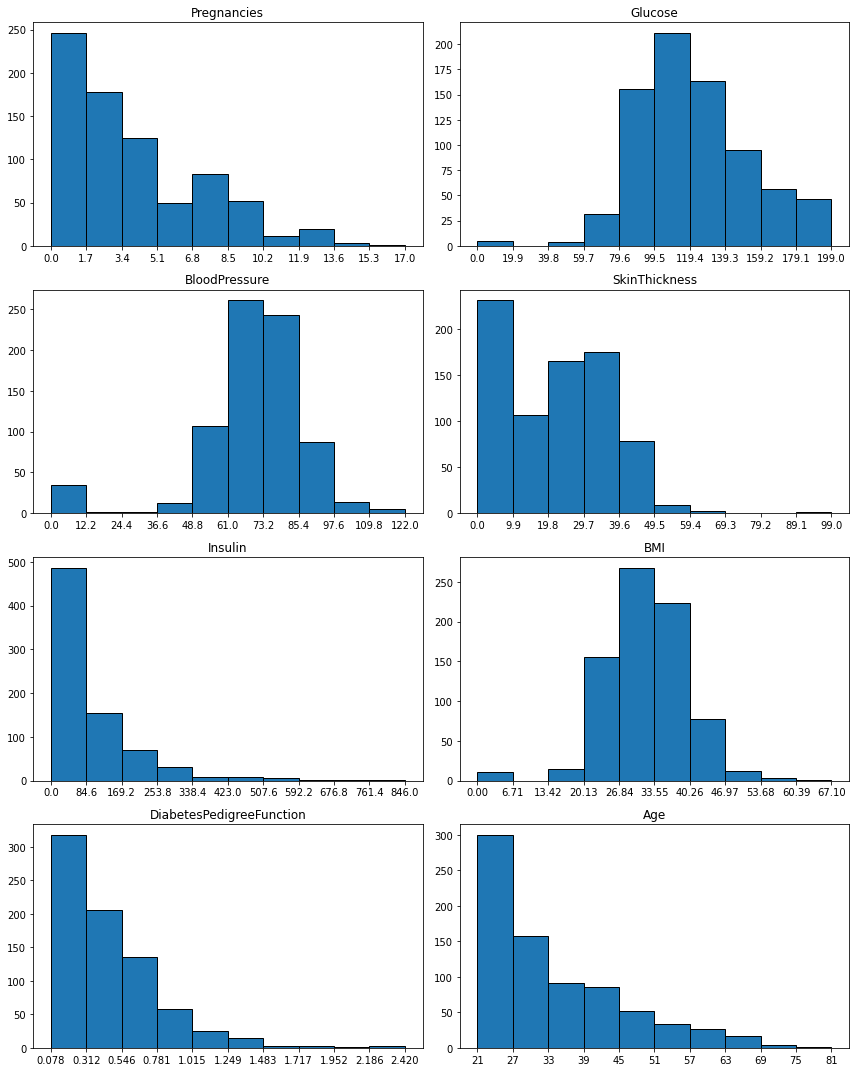

In [23]:
# Histogram by attribute
_, axes = pyplot.subplots(4, 2, figsize=(12, 15))
axes = axes.ravel()

for (col_name, ax) in zip(dataset.columns[:-1], axes):
    ax.set_title(col_name)
    _, bins, _ = ax.hist(dataset[col_name], histtype='bar', ec='black')
    ax.set_xticks(bins)
  
pyplot.tight_layout()

En su mayoría se observan distribuciones que parecen ser exponenciales (atributos Pregnancies, Insulin, DiabetesPedigreeFunction y Age). Por otra parte, los atributos Glucose y BMI parecen seguir distribuciones cercanas a la gaussiana.

También, por cada atributo, se crea un boxplot para visualizar que tanto varían sus valores y la posible presencia de outliers.

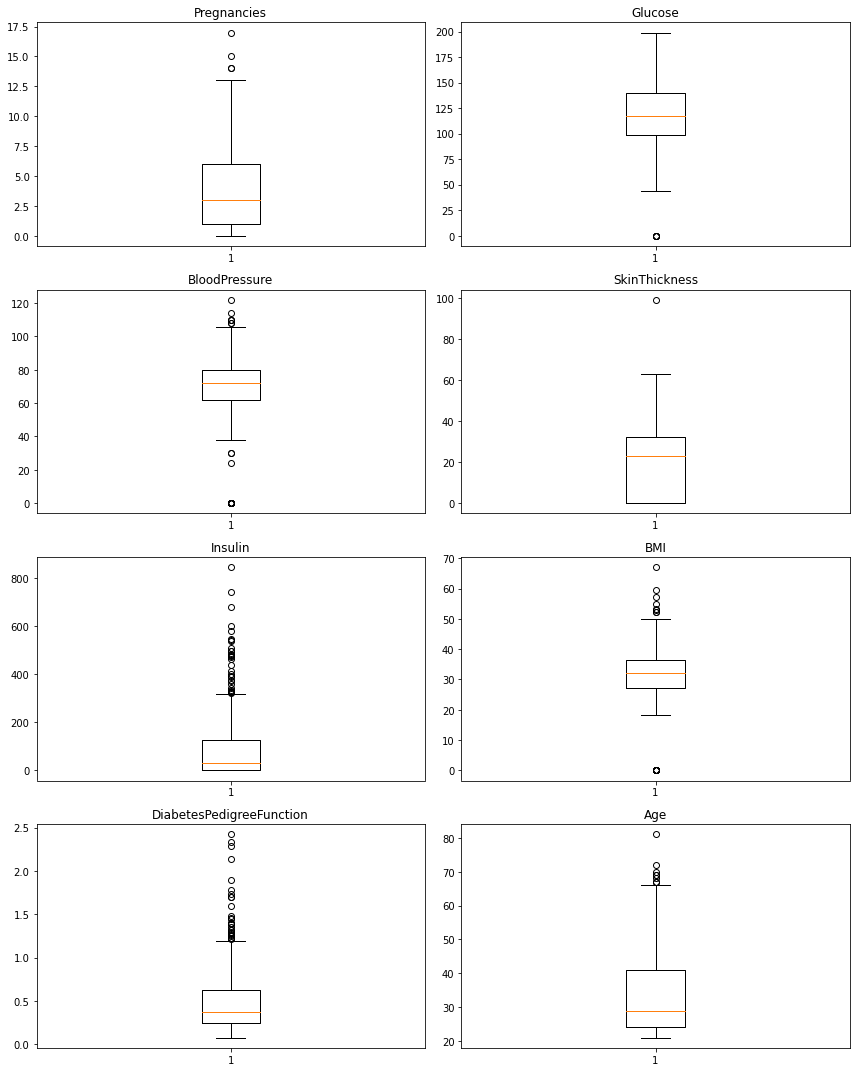

In [24]:
# Boxplot by attribute
_, axes = pyplot.subplots(4, 2, figsize=(12, 15))
axes = axes.ravel()

for (col_name, ax) in zip(dataset.columns[:-1], axes):
    ax.set_title(col_name)
    ax.boxplot(dataset[col_name])
  
pyplot.tight_layout()

En general, se observa que las cajas son estrechas, lo que implica que los valores situados entre los percentiles 25 y 75 de cada atributo suelen concentrarse en rangos de valores más bien acotados. Además, todos los atributos poseen outliers (sobretodo Insulin y DiabetesPedigreeFunction) y estos tienden a presentarse, en su mayoría, sobre el valor máximo de cada caso.

### 3.2 Gráficos multivariados

Se procede a construir gráficos que permitan visualizar las interacciones entre las variables del problema.

En primer lugar, se elabora un scatter plot por cada par de atributos.

[None, None, None, None]

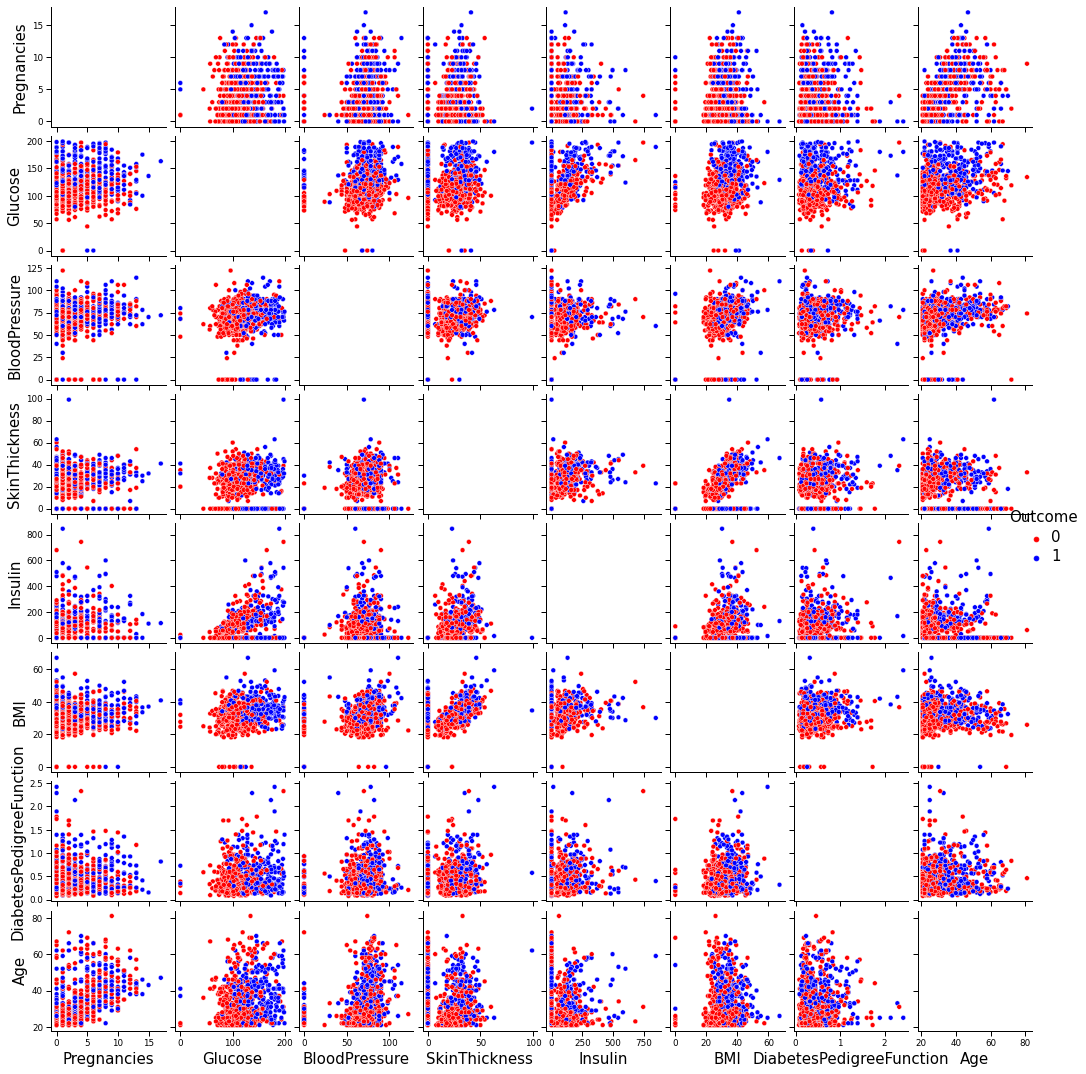

In [28]:
color_wheel = {0: 'red', 1: 'blue'}

seaborn.set_context('paper', rc={'axes.labelsize': 15})
scatter_plot_matrix = seaborn.pairplot(dataset, hue='Outcome', palette=color_wheel, diag_kind=[])
scatter_plot_matrix.fig.set_size_inches(15, 15)
pyplot.setp(scatter_plot_matrix._legend.get_title(), fontsize='15')
pyplot.setp(scatter_plot_matrix._legend.get_texts(), fontsize='15')

En términos generales, no se observan correlaciones bien definidas entre atributos. Quizás algunas correlaciones positivas, si bien débiles, pero dignas de mencionar se dan entre Insuline y Glucose, entre SkinThickness y BMI y entre Pregnancies y Age.

A propósito de lo anterior, se procede a visualizar las correlaciones existentes entre atributos:

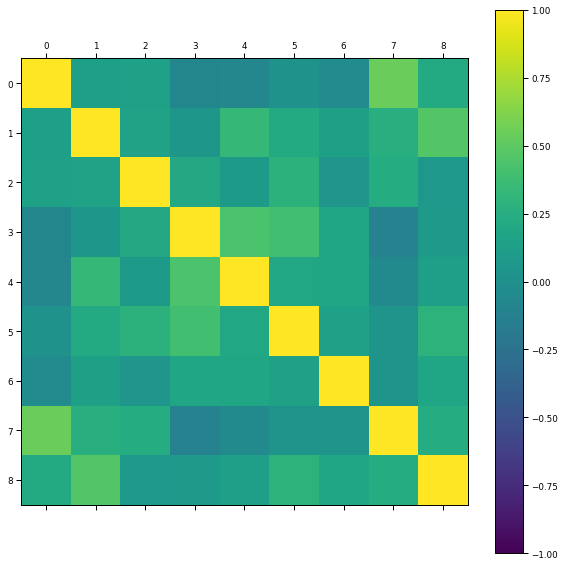

In [29]:
# Correlation matrix
fig = pyplot.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
cax = ax.matshow(dataset.corr(), vmin=-1, vmax=1, interpolation='none')
fig.colorbar(cax)
pyplot.show()

Efectivamente, las correlaciones entre atributos son más bien bajas. Quizás, las correlaciones que más se pueden destacar son las existentes entre Pregnancies (variable 0) y Age (variable 7) y entre SkinThickness (variable 3) e Insulin (variable 4), ambas positivas.

La figura también resulta útil para tener una idea de que tan correlacionados están los atributos con la variable dependiente (variable 8). Para este caso en particular, se observa que las correlaciones también son, en general, bajas, excepto con Glucose (variable 1), donde la relación es un poco más fuerte si se compara con los otros casos.  

Finalmente, se crea un histograma para ilustrar la distribución de clases de cada atributo.

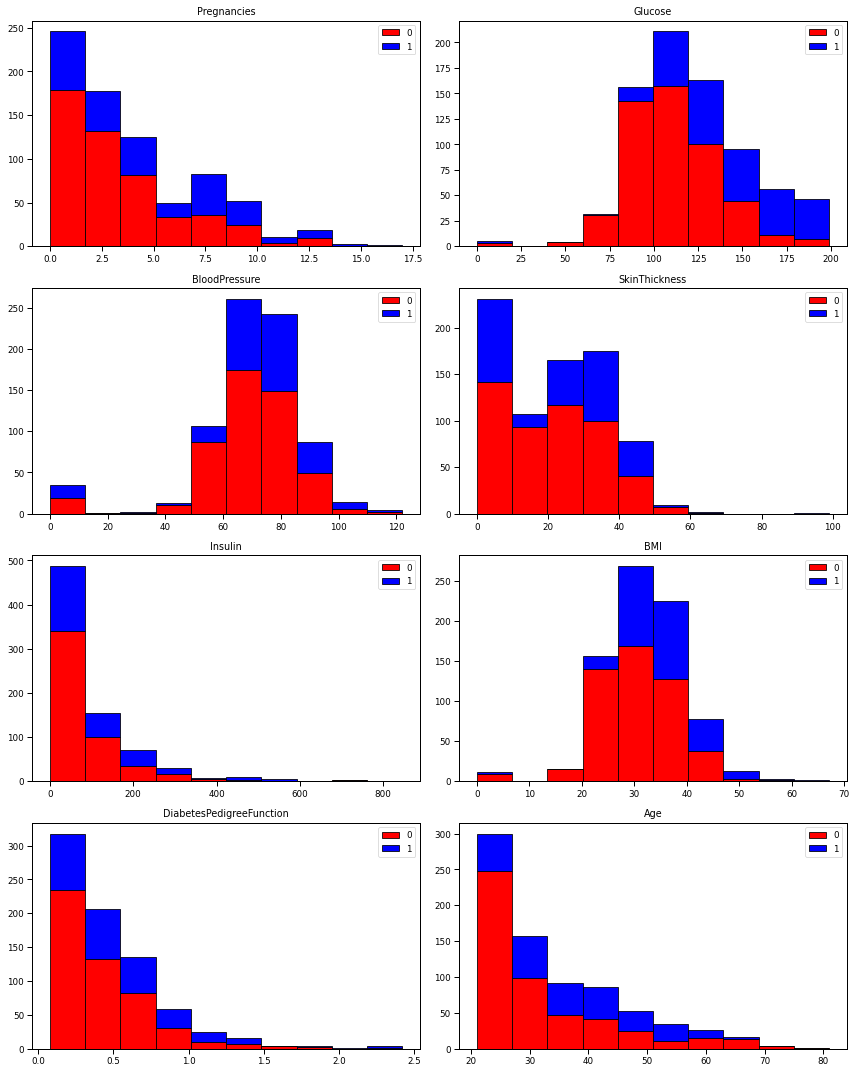

In [33]:
# Stacked histogram of each attribute by class
_, axes = pyplot.subplots(4, 2, figsize=(12, 15))
axes = axes.ravel()

for (col_name, ax) in zip(dataset.columns[:-1], axes):
    ax.set_title(col_name)
    _, bins, _ = ax.hist([dataset.loc[dataset['Outcome'] == x, col_name] for x in color_wheel.keys()],
                         histtype='bar', ec='black', stacked=True, 
                         color=list(color_wheel.values()), label=list(color_wheel.keys()))
    ax.legend(color_wheel.keys())

pyplot.tight_layout()

En los atributos que siguen distribuciones exponenciales (Pregnancies, Insulin, DiabetesPedigreeFunction y Age), la ausencia de diabetes tiende a ser predominante en los valores más bajos, mientras que para los valores más altos, la distribución de las clases tiende a ser más equitativa. Por otra parte, en los atributos que siguen distribuciones cuasi-gaussianas (Glucose y BMI) se observa que la presencia de diabetes se hace cada vez más fuerte al aumentar sus valores.

## 4. Preparación de datos

En esta sección se aplicarán todas aquellas operaciones de preparación que puedan ser ejecutadas sobre el conjunto de datos completo, esto es, que no provoquen una fuga de datos (data leakage).

### 4.1 Limpieza de datos 

Se examina la posible presencia de instancias repetidas en el dataset. En caso de que así sea, estas serán eliminadas con el fin de evitar estimaciones optimistas por parte de los modelos candidatos sobre datos no vistos.

In [35]:
# Report if there are any duplicates and list all duplicate rows
duplicates = dataset.duplicated()

if duplicates.any():
    print('Se encontraron', len(dataset[duplicates]), 'instancias duplicadas:')
    print('')
    print(dataset[duplicates])
else:
    print('No se encontraron filas duplicadas.')

No se encontraron filas duplicadas.


## 5. Comparación de algoritmos

### 5.1 Creación de conjunto de validación

El dataset es separado en dos partes:

- La primera, correspondiente al 80% de los datos, será utilizada para entrenar y estimar el rendimiento de los modelos candidatos. El conjunto de datos resultante quedará integrado por 614 instancias. 
- La segunda, correspondiente al 30% restante, será retenida y usada como conjunto de validación para, valga la redundancia, validar el rendimiento del modelo final sobre datos no vistos. El conjunto de datos resultante quedará integrado por 154 instancias.

Además, se estratificará para mantener las distribuciones de las clases tanto en el conjunto de entrenamiento como en el de validación.

In [3]:
# Separate input attributes from target variable
X = dataset.values[:, :-1].astype('float32')
Y = dataset.values[:, -1]

# Encode target variable to integer
le = LabelEncoder()
Y = le.fit_transform(Y)

# Split into train and validation sets
validation_size = 0.2
seed = 7

X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size, 
                                                                stratify=Y)

### 5.2 Definición de arnés de prueba

- Tomando en cuenta el desbalance existente entre las clases y lo fundamental que es reducir tanto el número de falsos negativos como de falsos positivos por la naturaleza del problema, se usará F1-score como métrica de evaluación de los modelos.

- Se usará stratified repeated k-fold cross validation con k = 10 y 3 repeticiones para estimar el F1-score de los mismos.

### 5.3 Definición de algoritmos candidatos

Se evaluarán los siguientes algoritmos para encontrar el modelo que se desea construir:

- Regresión logística
- LDA
- KNN
- Gaussian Naive Bayes (GNB)
- SVM
- Árbol de decisión
- Random Forest
- Extra Trees
- Adaboost
- Gradient Boosting
- MLP

Notar que es posible dividir los algoritmos en dos grupos:

- Grupo 1: Aquellos que son más sensibles a la escala y a la distribución de los atributos, así como también a la presencia de variables redundantes o irrelevantes. Estos algoritmos son: Regresión logística, LDA, KNN, GNB, SVM y MLP. De ahora en adelante, serán denominados algoritmos sensibles.


- Grupo 2: Aquellos que no debiesen ser sensibles ni a la escala ni a la distribución de los atributos, así como tampoco a la presencia de variables redundantes o irrelevantes. Estos algoritmos son: Árbol de decisión, Random Forest, Extra Trees, Adaboost y Gradient Boosting. De ahora en adelante, serán denominados algoritmos no sensibles.

### 5.4 Evaluación de algoritmos candidatos

Una nota importante: toda operación de preparación de datos ejecutada en esta sección será aplicada dentro de un pipeline para evitar la fuga de datos (data leakage). Además, todos los algoritmos serán evaluados con sus hiperparámetros por defecto, a menos que se indique lo contrario. En el caso de MLP, sin embargo, es pertinente definir su topología, la que es especificada a continuación:

- Una capa oculta integrada por 20 neuronas. Como activación, se utiliza la función ReLU.

- Capa de salida integrada por 2 neuronas (una por cada clase). Como activación, se utiliza la función softmax.

Durante el proceso de entrenamiento de la red, los pesos de la misma serán actualizados por medio de RMSprop (optimizador por defecto) y en base a la función de perdida binary crossentropy. Se entrenará durante 200 epochs, con un tamaño de mini-batch de 8.

Notar que para este caso en particular, la variable dependiente será convertida a una matriz booleana mediante one hot encoding.

Luego, la evaluación de los algoritmos se llevará a cabo en tres fases:

1. <b>Limpieza y transformación de datos</b>: Sobre cada uno de los algoritmos sensible, se estudiará el efecto de aplicar diferentes preparaciones de datos, las que considerarán operaciones tanto de limpieza como de tranformación de atributos. Sobre los no sensibles, en cambio, se aplicarán sólo operaciones de limpieza, considerando la baja sensibilidad que estos poseen respecto a las escalas y distribuciones de los atributos. Así, por cada algoritmo sensible se testeará el efecto de aplicar las siguientes dos operaciones de manera secuencial:  

- <b>Eliminación de columnas de baja varianza</b>: Si la varianza de una determinada columna es menor a cierto umbral previamente definido, entonces dicha columna será eliminada. Según lo observado en la sección 2.4.3, todos los atributos poseen una alta varianza, excepto por DiabetesPedigreeFunction, cuya varianza es de 0.11, aproximádamente. Así, el único umbral a evaluar será 0.15. También se estudiará el efecto de no aplicar esta operación ('passthrough').


- <b>Transformación de datos</b>: Se testearán los siguientes cambios de escala y/o de distribución por columnas (o filas, si es que así se indica):


    - Normalización por columnas
    - Estandarización
    - MaxAbsScaler
    - RobustScaler
    - Quantil Transform: Se evaluará con distribución de salida tanto gaussiana como uniforme. En ambos casos, el número de cuantiles será de 552, dado que cada fold de entrenamiento quedará integrado por 552 ó 553 observaciones.
    - Normalización por filas

Por cada algoritmo, se seleccionará la combinación de transformaciones que permita, en promedio, obtener el F1-score de prueba más alto. 


2. <b>Balanceo de clases</b>: Para cada configuración "transformación-algoritmo" obtenida de la fase 1, se estudiará el uso de las siguientes estrategias para abordar el desbalance en las clases:

- <b>Uso de algoritmos de data sampling</b>: Se considerarán cada una de las siguientes estrategias:

    - Aplicación de técnicas de oversampling
    - Aplicación de técnicas de undersampling
    - Aplicación de técnicas de oversampling, seguido por la aplicación de técnicas de undersampling
  
Las técnicas de oversampling a considerar serán las siguientes:
  
    - SMOTE
    - Borderline-SMOTE
    - SVM-SMOTE
    - ADASYN
    
Por otra parte, las técnicas de undersampling a considerar serán:

    - Condensed Nearest Neighbor Rule (CNN)
    - Near Miss Undersampling
    - Tomek Links Undersampling
    - Edited Nearest Neighbors Rule (ENN)
    - One-Sided Selection (OSS)
    - Neighborhood Cleaning Rule (NCR)

También se estudiará el efecto de no aplicar ninguna de estas operaciones.

- <b>Uso de algoritmos cost-sensitive</b>: Se modificará el costo de clasificar erróneamente una observación en los algoritmos de clasificación que lo permiten. Se permitirá que cada algoritmo ajuste automáticamente los costos en base a las distribuciones de las clases.

  Los algoritmos que permiten hacer esta modificación y que por tanto serán evaluados en esta sección son:
  
    - Regresión logística
    - SVM
    - MLP
    - Árbol de decisión
    - Random Forest
    - Extra Trees
    - Gradient Boosting


3. <b>Selección de atributos / reducción de dimensionalidad</b>: Para cada combinación "transformación-técnica de balanceo-algoritmo" obtenida de los puntos anteriores, se evaluará el efecto de reducir la dimensionalidad del espacio de entrada por medio de las siguientes técnicas:

- <b>SelectKBest</b>: Se seleccionarán los K atributos que estén más correlacionados con la variable dependiente en base a test ANOVA, con K variando entre 1 y el número de columnas resultante de la fase 1.


- <b>RFE</b>: Se seleccionarán los n atributos más importantes, con n variando entre 1 y el número de columnas resultante de la fase 1. Para la determinación de la importancia de los atributos, se estudiará, simultáneamente, el uso de diferentes algoritmos:


    - Regresión logística
    - LDA
    - Árbol de decisión
    - Random Forest
    - Extra Trees
    - AdaBoost
    - Gradient Boosting
    

- <b>PCA</b>: Se seleccionarán las n componentes principales, con n variando entre 1 y el número de columnas resultantes de la fase 1.

Además, también se evaluará el efecto de no aplicar ninguna de las estrategias anteriores.

Una vez evaluados, se seleccionarán los tres algoritmos que, en promedio, hayan obtenido el F1-score de prueba promedio más alto para posteriormente sintonizar sus hiperparámetros.

#### 5.4.1 Limpieza y transformación de datos

Se definen, en primer lugar, las operaciones de limpieza y transformación de datos y los algoritmos que serán evaluados.

In [128]:
# Define all VarianceThreshold possible configurations
variance_thresholds = ['passthrough', VarianceThreshold(threshold=0.15)]

# Define data transforms 
data_transforms = [
    MinMaxScaler(),
    StandardScaler(),
    MaxAbsScaler(),
    RobustScaler(),
    QuantileTransformer(n_quantiles=552, output_distribution='normal'),
    QuantileTransformer(n_quantiles=552, output_distribution='uniform'),
    Normalizer()
]

# Define sensible algorithms
# NOTE: MLP topology must be defined first

# Define MLP topology
def baseline_model():
    
    # Create model
    model = Sequential()
    model.add(Dense(20, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    
    # Compile model
    model.compile(loss='binary_crossentropy')
    
    return model

MLP = KerasClassifier(build_fn=baseline_model, epochs=200, batch_size=8, verbose=0)

sensible_algorithms = [
    LogisticRegression(),
    LDA(),
    KNN(),
    GNB(),
    SVC(),
    MLP
]

# Define non sensible algorithms
non_sensible_algorithms = [
    CART(),
    RF(),
    ET(),
    AB(),
    GB(random_state=seed)
]

Luego, se procede a evaluar a los algoritmos sensibles:

In [129]:
num_selected_columns_per_algorithm = []
best_result_per_algorithm = []
kfold = RepeatedStratifiedKFold(n_splits=10, n_repeats=3)

# Define data preparation pipelines for sensible algorithms and evaluate them
print('MEJOR CONFIGURACIÓN ENCONTRADA POR CADA ALGORITMO SENSIBLE')
print('-----------------------------------------------------------')
print('')

for algorithm in sensible_algorithms:
    
    best_cv_results = None
    best_test_mean_f1 = float('-inf')
    best_threshold = None
    best_transform = None
    
    for variance_threshold in variance_thresholds:
        for data_transform in data_transforms:
            
            pipeline = Pipeline([
                ('vt', variance_threshold), 
                ('dt', data_transform), 
                ('alg', algorithm)
            ])
            
            if algorithm != sensible_algorithms[-1]:
                
                cv_results = cross_validate(pipeline, X_train, Y_train, cv=kfold,
                                            scoring='f1', n_jobs=-1, 
                                            return_estimator=True, 
                                            return_train_score=True)
                
            else:
                
                cv_results = {}
                train_results = []
                test_results = []
                estimators = []
                
                for train_index, test_index in kfold.split(X_train, Y_train):
                    
                    X_train_kf, X_test_kf = X_train[train_index], X_train[test_index]
                    Y_train_kf, Y_test_kf = Y_train[train_index], Y_train[test_index]
                    
                    # Target variable one hot encoding
                    Y_train_kf_ohe = np_utils.to_categorical(Y_train_kf)
                    Y_test_kf_ohe = np_utils.to_categorical(Y_test_kf)
    
                    pipeline.fit(X_train_kf, Y_train_kf_ohe)
                    estimators.append(pipeline)
                    predicted_Y_train_kf = pipeline.predict(X_train_kf)
                    predicted_Y_test_kf = pipeline.predict(X_test_kf)
                    
                    train_results.append(f1_score(Y_train_kf, predicted_Y_train_kf))
                    test_results.append(f1_score(Y_test_kf, predicted_Y_test_kf))
                    
                cv_results['estimator'] = estimators
                cv_results['train_score'] = numpy.asarray(train_results)
                cv_results['test_score'] = numpy.asarray(test_results)
                
            if cv_results['test_score'].mean() > best_test_mean_f1:
                best_test_mean_f1 = cv_results['test_score'].mean()
                best_cv_results = cv_results
                best_threshold = variance_threshold
                best_transform = data_transform
                
    best_test_mean_f1_std = best_cv_results['test_score'].std()
    best_train_mean_f1 = best_cv_results['train_score'].mean()
    best_train_mean_f1_std = best_cv_results['train_score'].std()
    best_list_of_test_f1s = best_cv_results['test_score']
    
    vt_list = []

    total_num_folds = 30
    for i in range(total_num_folds):
        if best_cv_results['estimator'][i].named_steps['vt'] != 'passthrough':
            vt_list.append(len(best_cv_results['estimator'][i].named_steps['vt'].get_support(indices=True)))
    
    best_num_selected_columns = min(vt_list) if len(vt_list) != 0 else 8
    num_selected_columns_per_algorithm.append(best_num_selected_columns)
    
    best_result_per_algorithm.append(best_list_of_test_f1s)
    
    print('Algoritmo:', algorithm)
    print('Umbral varianza:', best_threshold)
    print('Número de columnas retenidas:', best_num_selected_columns)
    print('Transformación de datos:', best_transform)
    print('F1-score de entrenamiento promedio:', best_train_mean_f1)
    print('Desviación estándar del F1-score de entrenamiento:', best_train_mean_f1_std)
    print('F1-score de prueba promedio:', best_test_mean_f1)
    print('Desviación estándar del F1-score de prueba:', best_test_mean_f1_std)
    print('')

MEJOR CONFIGURACIÓN ENCONTRADA POR CADA ALGORITMO SENSIBLE
-----------------------------------------------------------

Algoritmo: LogisticRegression()
Umbral varianza: VarianceThreshold(threshold=0.15)
Número de columnas retenidas: 7
Transformación de datos: RobustScaler()
F1-score de entrenamiento promedio: 0.6630876812867377
Desviación estándar del F1-score de entrenamiento: 0.009422787959166684
F1-score de prueba promedio: 0.6520500465499552
Desviación estándar del F1-score de prueba: 0.08810917282253901

Algoritmo: LinearDiscriminantAnalysis()
Umbral varianza: VarianceThreshold(threshold=0.15)
Número de columnas retenidas: 7
Transformación de datos: QuantileTransformer(n_quantiles=552)
F1-score de entrenamiento promedio: 0.6734254391123818
Desviación estándar del F1-score de entrenamiento: 0.013444136464043374
F1-score de prueba promedio: 0.6670616230870379
Desviación estándar del F1-score de prueba: 0.08677967858051741

Algoritmo: KNeighborsClassifier()
Umbral varianza: VarianceT

El mejor resultado ha sido obtenidos por LDA, con un F1-score de prueba promedio 0.67 y desviación estándar de 0.09. No obstante, los rendimientos de los algoritmos son similares entre sí. Notar, además, que para 5 de los 6 algoritmos se eliminó el atributo DiabetesPedigreeFunction debido a su baja varianza y que para 3 de los 6 algoritmos se usó Quantile Transform, con distribución de salida uniforme, para la transformación de los atributos.

También, es relevante destacar que se observaron signos de subajuste no despreciables en la mayoría de los casos (excepto por MLP).

Ya evaluados los algoritmos "sensibles", se procede a evaluar los "no sensibles":

In [130]:
# Evaluate non sensible algorithms
print('RESULTADOS EVALUACIÓN DE ALGORITMOS NO SENSIBLES')
print('------------------------------------------------')
print('')

for algorithm in non_sensible_algorithms:
    
    best_cv_results = None
    best_test_mean_f1 = float('-inf')
    best_threshold = None
    
    for variance_threshold in variance_thresholds:
        
        pipeline = Pipeline([
            ('vt', variance_threshold), 
            ('alg', algorithm)
        ])
        
        cv_results = cross_validate(pipeline, X_train, Y_train, cv=kfold, 
                                    scoring='f1', n_jobs=-1, 
                                    return_estimator=True, 
                                    return_train_score=True)
        
        if cv_results['test_score'].mean() > best_test_mean_f1:
            best_test_mean_f1 = cv_results['test_score'].mean()
            best_cv_results = cv_results
            best_threshold = variance_threshold

    best_test_mean_f1_std = best_cv_results['test_score'].std()
    best_train_mean_f1 = best_cv_results['train_score'].mean()
    best_train_mean_f1_std = best_cv_results['train_score'].std()
    best_list_of_test_f1s = best_cv_results['test_score']
                
    vt_list = []
    
    total_num_folds = 30
    for i in range(total_num_folds):
        if best_cv_results['estimator'][i].named_steps['vt'] != 'passthrough':
            vt_list.append(len(best_cv_results['estimator'][i].named_steps['vt'].get_support(indices=True)))
                
    best_num_selected_columns = min(vt_list) if len(vt_list) != 0 else 8
    num_selected_columns_per_algorithm.append(best_num_selected_columns)
    
    best_result_per_algorithm.append(best_list_of_test_f1s)
    
    print('Algoritmo:', algorithm)
    print('Umbral varianza:', best_threshold)
    print('Número de columnas retenidas:', best_num_selected_columns)
    print('F1-score de entrenamiento promedio:', best_train_mean_f1)
    print('Desviación estándar del F1-score de entrenamiento:', best_train_mean_f1_std)
    print('F1-score de prueba promedio:', best_test_mean_f1)
    print('Desviación estándar del F1-score de prueba:', best_test_mean_f1_std)
    print('')

RESULTADOS EVALUACIÓN DE ALGORITMOS NO SENSIBLES
-------------------------------------------------

Algoritmo: DecisionTreeClassifier()
Umbral varianza: passthrough
Número de columnas retenidas: 8
F1-score de entrenamiento promedio: 1.0
Desviación estándar del F1-score de entrenamiento: 0.0
F1-score de prueba promedio: 0.6061083638799238
Desviación estándar del F1-score de prueba: 0.07739620497814102

Algoritmo: RandomForestClassifier()
Umbral varianza: VarianceThreshold(threshold=0.15)
Número de columnas retenidas: 7
F1-score de entrenamiento promedio: 1.0
Desviación estándar del F1-score de entrenamiento: 0.0
F1-score de prueba promedio: 0.6547878918071771
Desviación estándar del F1-score de prueba: 0.07978114512550442

Algoritmo: ExtraTreesClassifier()
Umbral varianza: VarianceThreshold(threshold=0.15)
Número de columnas retenidas: 7
F1-score de entrenamiento promedio: 1.0
Desviación estándar del F1-score de entrenamiento: 0.0
F1-score de prueba promedio: 0.6417274830298412
Desviaci

Los resultados muestran que, excepto por Random Forest y Gradient Boosting, los algoritmos no sensibles obtienen rendimientos siempre inferiores a los de los algoritmos sensibles. Notar también que para 3 de los 5 algoritmos, se eliminó el atributo DiabetesPedigreeFunction debido a su baja varianza. Además, a diferencia del caso sensible, se observan altos niveles de sobreajuste en todos los casos.

Así, LDA continúa siendo el algoritmo que exhibe el F1-score de prueba promedio más alto. 

Con el fin de visualizar mejor los resultados, se construye, por cada algoritmo, un boxplot que muestra la distribución de F1-scores obtenida a partir de la mejor preparación de datos encontrada.

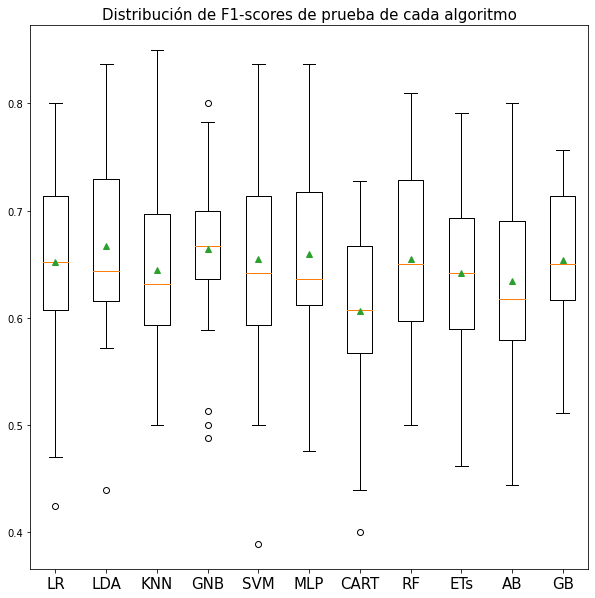

In [131]:
algorithms_names = [
    'LR',
    'LDA',
    'KNN',
    'GNB',
    'SVM',
    'MLP',
    'CART',
    'RF',
    'ETs',
    'AB',
    'GB'
]

fig = pyplot.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

ax.set_title('Distribución de F1-scores de prueba de cada algoritmo')
ax.title.set_fontsize(15)

ax.boxplot(best_result_per_algorithm, labels=algorithms_names, showmeans=True)

for algorithm_label in ax.get_xticklabels():
    algorithm_label.set_fontsize(15)
    
for accuracy_label in ax.get_yticklabels():
    accuracy_label.set_fontsize(15)


    pyplot.show()

La figura anterior confirma el mejor rendimiento de LDA, al ser quien alcanza el F1-score de prueba promedio más altos. Ahora bien, los boxplots dan cuenta de una alta varianza en los resultados de todos los algoritmos, excepto (quizás) en el caso de GNB.

#### 5.4.2 Balanceo de clases

##### 5.4.2.1 Uso de algoritmos de data sampling

Se procede a evaluar las diferentes estrategias de data sampling definidas previamente.

In [153]:
# Define pipelines
best_result_per_pipeline = []

pipelines = [
    
    # Logistic Regression pipeline
    make_pipeline(
        VarianceThreshold(threshold=0.15),
        RobustScaler(),
        LogisticRegression()
    ),
    
    # LDA pipeline
    make_pipeline(
        VarianceThreshold(threshold=0.15),
        QuantileTransformer(n_quantiles=552, output_distribution='uniform'),
        LDA()
    ),

    # KNN pipeline
    make_pipeline(
        VarianceThreshold(threshold=0.15),
        QuantileTransformer(n_quantiles=552, output_distribution='uniform'),
        KNN()
    ),
        
    # Gaussian Naive Bayes pipeline
    make_pipeline(
        'passthrough',
        MaxAbsScaler(),
        GNB()
    ),
    
    # SVM pipeline
    make_pipeline(
        VarianceThreshold(threshold=0.15),
        QuantileTransformer(n_quantiles=552, output_distribution='uniform'),
        SVC()
    ),

    # MLP pipeline
    make_pipeline(
        VarianceThreshold(threshold=0.15),
        StandardScaler(),
        MLP
    ),
    
    # CART pipeline
    make_pipeline(
        'passthrough', 
        CART()
    ),
    
    # Random Forest pipeline
    make_pipeline(
        VarianceThreshold(threshold=0.15),
        RF()
    ),
    
    # Extra Trees pipeline
    make_pipeline(
        VarianceThreshold(threshold=0.15), 
        ET()
    ),
    
    # Adaboost pipeline
    make_pipeline(
        'passthrough', 
        AB()
    ),
    
    # Gradient boosting pipeline
    make_pipeline(
        VarianceThreshold(threshold=0.15),
        GB(random_state=seed)
    )
]

# Define oversamplers 
oversamplers = [
    
    'passthrough',
    
    SMOTE(random_state=seed, 
          n_jobs=-1),
    
    BorderlineSMOTE(random_state=seed, 
                    n_jobs=-1),
    
    SVMSMOTE(random_state=seed, 
            n_jobs=-1),
    
    ADASYN(random_state=seed, 
          n_jobs=-1)
]

# Define undersamplers
undersamplers = [
    
    'passthrough',
    
    CondensedNearestNeighbour(random_state=seed, 
                              n_jobs=-1),
    
    NearMiss(n_jobs=-1),
    
    TomekLinks(n_jobs=-1),
    
    EditedNearestNeighbours(n_jobs=-1),
    
    NeighbourhoodCleaningRule(n_jobs=-1)
]

print('MEJOR CONFIGURACIÓN ENCONTRADA POR CADA PIPELINE')
print('-------------------------------------------------')
print('')

for pipeline in pipelines:
    
    best_cv_results = None
    best_test_mean_f1 = float('-inf')
    best_oversampler = None
    best_undersampler = None
    
    for oversampler in oversamplers:
        for undersampler in undersamplers:
            
            if oversampler != 'passthrough' and undersampler != 'passthrough':
                undersampler.set_params(sampling_strategy='all')
                
            elif oversampler == 'passthrough' and undersampler != 'passthrough':
                    undersampler.set_params(sampling_strategy='auto')
                
            pipeline_temp = clone(pipeline)
            pipeline_temp.steps.insert(-1, ('os', oversampler))
            pipeline_temp.steps.insert(-1, ('us', undersampler))
            
            if type(pipeline_temp[-1]) != KerasClassifier:
                
                cv_results = cross_validate(pipeline_temp, X_train, Y_train,
                                            cv=kfold, scoring='f1', 
                                            n_jobs=-1, return_train_score=True)
            else:
                
                cv_results = {}
                train_results = []
                test_results = []
                
                for train_index, test_index in kfold.split(X_train, Y_train):
                    
                    X_train_kf, X_test_kf = X_train[train_index], X_train[test_index]
                    Y_train_kf, Y_test_kf = Y_train[train_index], Y_train[test_index]
                    
                    # Target variable one hot encoding
                    Y_train_kf_ohe = np_utils.to_categorical(Y_train_kf)
                    Y_test_kf_ohe = np_utils.to_categorical(Y_test_kf)
                    
                    pipeline_temp.fit(X_train_kf, Y_train_kf_ohe)
                    predicted_Y_train_kf = pipeline_temp.predict(X_train_kf)
                    predicted_Y_test_kf = pipeline_temp.predict(X_test_kf)
                    
                    train_results.append(f1_score(Y_train_kf, predicted_Y_train_kf))
                    test_results.append(f1_score(Y_test_kf, predicted_Y_test_kf))
                
                cv_results['train_score'] = numpy.asarray(train_results)
                cv_results['test_score'] = numpy.asarray(test_results)
                
            if cv_results['test_score'].mean() > best_test_mean_f1:
                best_test_mean_f1 = cv_results['test_score'].mean()
                best_cv_results = deepcopy(cv_results)
                best_oversampler = deepcopy(pipeline_temp['os'])
                best_undersampler = deepcopy(pipeline_temp['us'])
            
    best_test_mean_f1_std = best_cv_results['test_score'].std()
    best_train_mean_f1 = best_cv_results['train_score'].mean()
    best_train_mean_f1_std = best_cv_results['train_score'].std()
    best_list_of_test_f1s = best_cv_results['test_score']
                                            
    best_result_per_pipeline.append(best_list_of_test_f1s)
    
    print('Algoritmo:', pipeline[-1])
    print('Pipeline limpieza y transformación de datos:', pipeline.steps[:-1])
    print('Método de oversampling:', best_oversampler)
    print('Método de undersampling:', best_undersampler)
    print('F1-score de entrenamiento promedio:', best_train_mean_f1)
    print('Desviación estándar del F1-score de entrenamiento:', best_train_mean_f1_std)
    print('F1-score de prueba promedio:', best_test_mean_f1)
    print('Desviación estándar del F1-score de prueba:', best_test_mean_f1_std)
    print('')

MEJOR CONFIGURACIÓN ENCONTRADA POR CADA PIPELINE
-------------------------------------------------

Algoritmo: LogisticRegression()
Pipeline limpieza y transformación de datos: [('variancethreshold', VarianceThreshold(threshold=0.15)), ('robustscaler', RobustScaler())]
Método de oversampling: passthrough
Método de undersampling: NearMiss(n_jobs=-1)
F1-score de entrenamiento promedio: 0.6925453128569771
Desviación estándar del F1-score de entrenamiento: 0.0084701663983208
F1-score de prueba promedio: 0.6853153466356708
Desviación estándar del F1-score de prueba: 0.05979084304322655

Algoritmo: LinearDiscriminantAnalysis()
Pipeline limpieza y transformación de datos: [('variancethreshold', VarianceThreshold(threshold=0.15)), ('quantiletransformer', QuantileTransformer(n_quantiles=552))]
Método de oversampling: passthrough
Método de undersampling: NeighbourhoodCleaningRule(n_jobs=-1)
F1-score de entrenamiento promedio: 0.7020472275850138
Desviación estándar del F1-score de entrenamiento: 

Los resultados muestran que, excepto por MLP, todos los algoritmos se ven beneficiados por el uso de técnicas de data sampling, experimentando aumentos de entre 0.02 y 0.06 en sus F1-score de prueba promedio. El algoritmo que alcanza el mejor resultado es Random Forest, con F1-score de prueba promedio de 0.71 y desviación estándar de 0.06 Notar que de los 11 algoritmos en cuestión, 1 hizo uso de sólo oversampling, 4 de sólo undersampling y 6 de ambas técnicas. El método de oversampling más usado fue ADASYN, mientras que el de undersampling fue ENN.

Para una mejor ilustración de los resultados, se construye un boxplot con la distribución de F1-scores de prueba de cada mejor configuración.

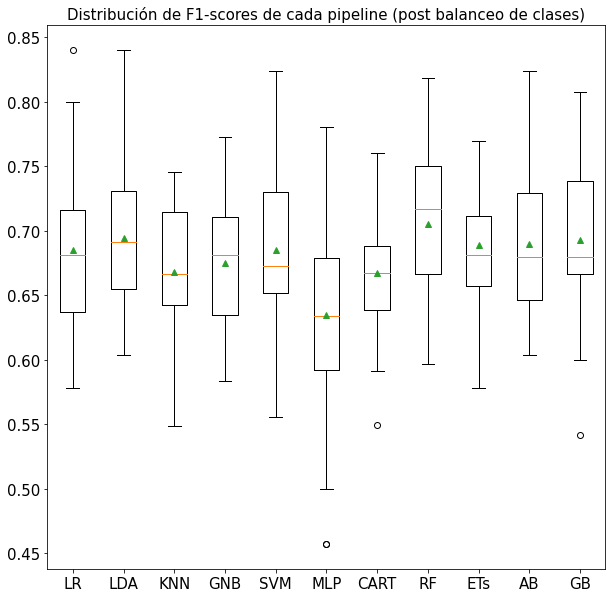

In [159]:
fig = pyplot.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

ax.set_title('Distribución de F1-scores de cada pipeline (post balanceo de clases)')
ax.title.set_fontsize(15)

ax.boxplot(best_result_per_pipeline, labels=algorithms_names, showmeans=True)

for algorithm_label in ax.get_xticklabels():
    algorithm_label.set_fontsize(15)
    
for accuracy_label in ax.get_yticklabels():
    accuracy_label.set_fontsize(15)

pyplot.show()

En comparación con los boxplots "pre data sampling", se observa una generalizada reducción de las varianzas en las distribuciones de F1-scores de prueba, si bien estas continúan siendo altas.

##### 5.4.2.2 Uso de algoritmos cost-sensitive

De acuerdo a lo señalado con anterioridad, se procede a ajustar el peso de cada clase en base a su distribución en aquellos algoritmos que lo permiten.

In [168]:
# Class weights for MLP must be defined explicitly
balanced_weights_array = compute_class_weight('balanced', numpy.unique(Y_train), Y_train)
balanced_weights_dict = {0: balanced_weights_array[0], 1: balanced_weights_array[1]}
weighted_MLP = KerasClassifier(build_fn=baseline_model, epochs=200, 
                               batch_size=8, class_weight=balanced_weights_dict, 
                               verbose=0)

# Define pipelines
result_per_pipeline = []

pipelines = [
    
    # Logistic Regression pipeline
    make_pipeline(
        VarianceThreshold(threshold=0.15),
        RobustScaler(),
        LogisticRegression(class_weight='balanced')
    ),

    # SVM pipeline
    make_pipeline(
        VarianceThreshold(threshold=0.15),
        QuantileTransformer(n_quantiles=552, output_distribution='uniform'),
        SVC(class_weight='balanced')
    ),

    # MLP pipeline
    make_pipeline(
        VarianceThreshold(threshold=0.15),
        StandardScaler(),
        weighted_MLP
    ),
    
    # CART pipeline
    make_pipeline(
        'passthrough',
        CART(class_weight='balanced')
    ),
    
    # Random Forest pipeline
    make_pipeline(
        VarianceThreshold(threshold=0.15),
        RF(class_weight='balanced')
    ),
    
    # Extra Trees pipeline
    make_pipeline(
        VarianceThreshold(threshold=0.15), 
        ET(class_weight='balanced')
    ),
        
    # Gradient boosting pipeline
    make_pipeline(
        VarianceThreshold(threshold=0.15),
        GB(class_weight='balanced', random_state=seed)
    )
]

print('EVALUACIÓN DE ALGORITMOS COST-SENSITIVE')
print('---------------------------------------')
print('')

for pipeline in pipelines:
    
    if type(pipeline[-1]) != KerasClassifier:
        
        cv_results = cross_validate(pipeline, X_train, Y_train,
                                    cv=kfold, scoring='f1', 
                                    n_jobs=-1, return_train_score=True)
    else:
        
        cv_results = {}
        train_results = []
        test_results = []
                
        for train_index, test_index in kfold.split(X_train, Y_train):
            
            X_train_kf, X_test_kf = X_train[train_index], X_train[test_index]
            Y_train_kf, Y_test_kf = Y_train[train_index], Y_train[test_index]
                    
            # Target variable one hot encoding
            Y_train_kf_ohe = np_utils.to_categorical(Y_train_kf)
            Y_test_kf_ohe = np_utils.to_categorical(Y_test_kf)
            
            pipeline.fit(X_train_kf, Y_train_kf_ohe)
            predicted_Y_train_kf = pipeline.predict(X_train_kf)
            predicted_Y_test_kf = pipeline.predict(X_test_kf)
            
            train_results.append(f1_score(Y_train_kf, predicted_Y_train_kf))
            test_results.append(f1_score(Y_test_kf, predicted_Y_test_kf))
        
        cv_results['train_score'] = numpy.asarray(train_results)
        cv_results['test_score'] = numpy.asarray(test_results)
    
    result_per_pipeline.append(cv_results['test_score'])

    print('Algoritmo:', pipeline[-1])
    print('Pipeline limpieza y transformación de datos:', pipeline.steps[:-1])
    print('F1-score de entrenamiento promedio:', cv_results['train_score'].mean())
    print('Desviación estándar del F1-score de entrenamiento:', cv_results['train_score'].std())
    print('F1-score de prueba promedio:', cv_results['test_score'].mean())
    print('Desviación estándar del F1-score de prueba:', cv_results['test_score'].std())
    print('')

EVALUACIÓN DE ALGORITMOS COST-SENSITIVE
---------------------------------------

Algoritmo: LogisticRegression(class_weight='balanced')
Pipeline limpieza y transformación de datos: [('variancethreshold', VarianceThreshold(threshold=0.15)), ('robustscaler', RobustScaler())]
F1-score de entrenamiento promedio: 0.6873898666606463
Desviación estándar del F1-score de entrenamiento: 0.0098229664891145
F1-score de prueba promedio: 0.6752907408743831
Desviación estándar del F1-score de prueba: 0.07497222030097281

Algoritmo: SVC(class_weight='balanced')
Pipeline limpieza y transformación de datos: [('variancethreshold', VarianceThreshold(threshold=0.15)), ('quantiletransformer', QuantileTransformer(n_quantiles=552))]
F1-score de entrenamiento promedio: 0.740949328208248
Desviación estándar del F1-score de entrenamiento: 0.007156078989253016
F1-score de prueba promedio: 0.67020483510828
Desviación estándar del F1-score de prueba: 0.05636063817317491

Algoritmo: <tensorflow.python.keras.wrappers

[06:24:12] WARNING: ../src/learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[06:24:13] WARNING: ../src/learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[06:24:13] WARNING: ../src/learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[06:

Excepto por MLP, todos los algoritmos obtienen peores resultados al ajustar los pesos de las clases en comparación con aplicar técnicas de data sampling. En el caso de MLP, se obtiene un aumento de aproximadamente 0.02 en su F1-score de prueba promedio.

#### 5.4.3 Selección de atributos / reducción de dimensionalidad

Ya encontradas las operaciones de limpieza / transformación / balanceo de datos que permiten a los algoritmos obtener sus F1-scores de prueba promedio más altos, se procede a evaluar cada una de las estrategias de selección de características definidas con anterioridad. En el caso de MLP, recordar, no se hará aplicación previa de técnicas de data sampling, si no que se ajustarán los pesos de las clases, por lo que de ahora en adelante el modelo será denominado como weighted MLP.

In [202]:
# Define pipelines
best_result_per_pipeline = []

pipelines = [
    
    # Logistic Regression pipeline
    make_pipeline(
        VarianceThreshold(threshold=0.15),
        RobustScaler(),
        'passthrough',
        NearMiss(n_jobs=-1),
        'passthrough',
        LogisticRegression()
    ),
        
    # LDA pipeline
    make_pipeline(
        VarianceThreshold(threshold=0.15),
        QuantileTransformer(n_quantiles=552, output_distribution='uniform'),
        'passthrough',
        NeighbourhoodCleaningRule(n_jobs=-1),
        'passthrough',
        LDA()
    ),
    
    # KNN pipeline
    make_pipeline(
        VarianceThreshold(threshold=0.15),
        QuantileTransformer(n_quantiles=552, output_distribution='uniform'),
        SMOTE(n_jobs=-1, random_state=seed),
        NeighbourhoodCleaningRule(n_jobs=-1, sampling_strategy='all'),
        'passthrough',
        KNN()
    ),
        
    # Gaussian Naive Bayes pipeline
    make_pipeline(
        'passthrough',
        MaxAbsScaler(),
        ADASYN(n_jobs=-1, random_state=seed),
        'passthrough',
        'passthrough',
        GNB()
    ),
    
    # SVM pipeline
    make_pipeline(
        VarianceThreshold(threshold=0.15),
        QuantileTransformer(n_quantiles=552, output_distribution='uniform'),
        'passthrough',
        CondensedNearestNeighbour(n_jobs=-1, random_state=seed),
        'passthrough',
        SVC()
    ),
    
    # MLP pipeline
    make_pipeline(
        VarianceThreshold(threshold=0.15),
        StandardScaler(),
        'passthrough',
        'passthrough',
        'passthrough',
        weighted_MLP
    ),
    
    # CART pipeline
    make_pipeline(
        'passthrough', 
        ADASYN(n_jobs=-1, random_state=seed),
        EditedNearestNeighbours(n_jobs=-1, sampling_strategy='all'),
        'passthrough',
        CART()
    ),
    
    # Random Forest pipeline
    make_pipeline(
        VarianceThreshold(threshold=0.15),
        ADASYN(n_jobs=-1, random_state=seed),
        EditedNearestNeighbours(n_jobs=-1, sampling_strategy='all'),
        'passthrough',
        RF()
    ),
    
    # Extra Trees pipeline
    make_pipeline(
        VarianceThreshold(threshold=0.15), 
        SMOTE(n_jobs=-1, random_state=seed),
        NeighbourhoodCleaningRule(n_jobs=-1, sampling_strategy='all'),
        'passthrough',
        ET()
    ),
    
    # Adaboost pipeline
    make_pipeline(
        'passthrough',
        SVMSMOTE(n_jobs=-1, random_state=seed),
        EditedNearestNeighbours(n_jobs=-1, sampling_strategy='all'),
        'passthrough',
        AB()
    ),
    
    # Gradient boosting pipeline
    make_pipeline(
        VarianceThreshold(threshold=0.15),
        BorderlineSMOTE(n_jobs=-1, random_state=seed),
        EditedNearestNeighbours(n_jobs=-1, sampling_strategy='all'),
        'passthrough',
        GB(random_state=seed)
    )
]

RFE_estimator = [LogisticRegression(), LDA(), CART(), RF(), ET(), AB(), GB(random_state=seed)]

print('MEJOR CONFIGURACIÓN ENCONTRADA POR CADA PIPELINE')
print('-------------------------------------------------')
print('')

for (pipeline, num_selected_columns) in zip(pipelines, num_selected_columns_per_algorithm):
    
    # Define all feature selection / dimensionality num_selected_columnspossible configurations for each pipeline
    possible_num_columns = range(1, num_selected_columns)
    
    SelectKBest_combinations = [SelectKBest(k=k) for k in possible_num_columns]
    
    RFE_combinations = []
    for estimator in RFE_estimator:
        for n_features_to_select in possible_num_columns:
            RFE_combinations.append(RFE(estimator=estimator, n_features_to_select=n_features_to_select))
            
    PCA_combinations = [PCA(n_components=n_components) for n_components in possible_num_columns]
    
    fs_methods = ['passthrough'] + SelectKBest_combinations + RFE_combinations + PCA_combinations
    
    best_cv_results = None
    best_test_mean_f1 = float('-inf')
    best_fs_method = None
    
    for fs_method in fs_methods:
        
        with warnings.catch_warnings():
            warnings.simplefilter('error')
            
            try:
                pipeline.steps[-2] = ('fs', fs_method)
                
                if type(pipeline[-1]) != KerasClassifier:
                    cv_results = cross_validate(pipeline, X_train, Y_train,
                                                cv=kfold, scoring='f1', 
                                                n_jobs=-1, return_train_score=True)
                    
                else:
                    
                    cv_results = {}
                    train_results = []
                    test_results = []
                    
                    for train_index, test_index in kfold.split(X_train, Y_train):
                        
                        X_train_kf, X_test_kf = X_train[train_index], X_train[test_index]
                        Y_train_kf, Y_test_kf = Y_train[train_index], Y_train[test_index]
                        
                        # Target variable one hot encoding
                        Y_train_kf_ohe = np_utils.to_categorical(Y_train_kf)
                        Y_test_kf_ohe = np_utils.to_categorical(Y_test_kf)
                        
                        pipeline.fit(X_train_kf, Y_train_kf_ohe)
                        predicted_Y_train_kf = pipeline.predict(X_train_kf)
                        predicted_Y_test_kf = pipeline.predict(X_test_kf)
                        
                        train_results.append(f1_score(Y_train_kf, predicted_Y_train_kf))
                        test_results.append(f1_score(Y_test_kf, predicted_Y_test_kf))
                    
                    cv_results['train_score'] = numpy.asarray(train_results)
                    cv_results['test_score'] = numpy.asarray(test_results)
                
                if cv_results['test_score'].mean() > best_test_mean_f1:
                    best_test_mean_f1 = cv_results['test_score'].mean()
                    best_cv_results = deepcopy(cv_results)
                    best_fs_method = deepcopy(pipeline['fs'])

            except:
                pass
            
    best_test_mean_f1_std = best_cv_results['test_score'].std()
    best_train_mean_f1 = best_cv_results['train_score'].mean()
    best_train_mean_f1_std = best_cv_results['train_score'].std()
    best_list_of_test_f1s = best_cv_results['test_score']
                                            
    best_result_per_pipeline.append(best_list_of_test_f1s)
    
    print('Algoritmo:', pipeline[-1])
    print('Pipeline limpieza y transformación de datos / balanceo de clases:', pipeline.steps[:-2])
    print('Selección de características / reducción de dimensionalidad:', best_fs_method)                             
    print('F1-score de entrenamiento promedio:', best_train_mean_f1)
    print('Desviación estándar del F1-score de entrenamiento:', best_train_mean_f1_std)
    print('F1-score de prueba promedio:', best_test_mean_f1)
    print('Desviación estándar del F1-score de prueba:', best_test_mean_f1_std)
    print('')

MEJOR CONFIGURACIÓN ENCONTRADA POR CADA PIPELINE
-------------------------------------------------

Algoritmo: LogisticRegression()
Pipeline limpieza y transformación de datos / balanceo de clases: [('variancethreshold', VarianceThreshold(threshold=0.15)), ('robustscaler', RobustScaler()), ('passthrough-1', 'passthrough'), ('nearmiss', NearMiss(n_jobs=-1))]
Selección de características / reducción de dimensionalidad: RFE(estimator=RandomForestClassifier(), n_features_to_select=5)
F1-score de entrenamiento promedio: 0.6969538361614827
Desviación estándar del F1-score de entrenamiento: 0.01013021752121105
F1-score de prueba promedio: 0.6981058611790523
Desviación estándar del F1-score de prueba: 0.06771134277133455

Algoritmo: LinearDiscriminantAnalysis()
Pipeline limpieza y transformación de datos / balanceo de clases: [('variancethreshold', VarianceThreshold(threshold=0.15)), ('quantiletransformer', QuantileTransformer(n_quantiles=552)), ('passthrough-1', 'passthrough'), ('neighbourhoo

Es unánime: la selección de características logra mejorar los resultados en todos los casos, excepto en Random Forest, donde el F1-score de prueba promedio es prácticamente idéntico al obtenido en la fase anterior, y en LDA, donde el mejor resultado fue conseguido sin hacer selección de características. Los aumentos en la métrica de evaluación oscilan entre 0.002 y 0.03.

Notar que en 8 de los 11 casos, el mejor resultado se obtuvo al realizar la selección de características por medio de RFE y en los 2 casos restantes, a través de SelectKBest. Indepediente de la técnica utilizada, se seleccionaron 4 atributos en 4 de los casos, 3 atributos en 3 de los casos y 5 atributos en los 3 casos restantes.

Para una mejor visualización de los resultados, se construye, por cada pipeline, un boxplot con sus distribuciones de F1-scores de prueba en base a las mejores preparaciones (limpieza / transformación / balanceo / selección de características) encontradas para cada uno.

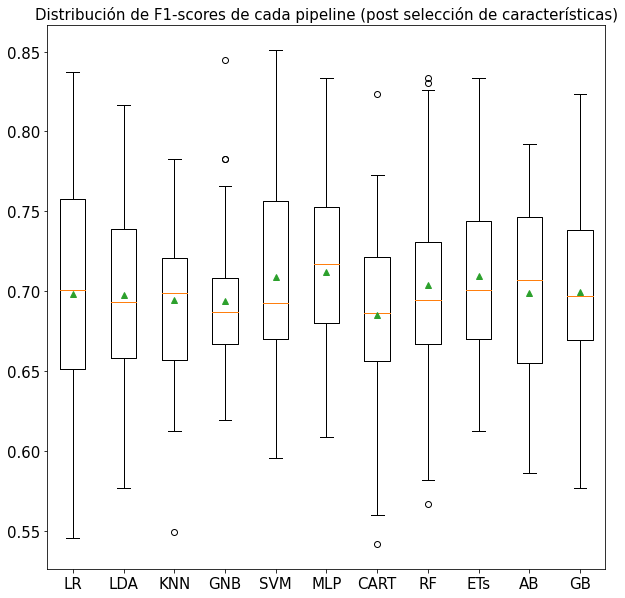

In [203]:
fig = pyplot.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

ax.set_title('Distribución de F1-scores de cada pipeline (post selección de características)')
ax.title.set_fontsize(15)

ax.boxplot(best_result_per_pipeline, labels=algorithms_names, showmeans=True)

for algorithm_label in ax.get_xticklabels():
    algorithm_label.set_fontsize(15)
    
for accuracy_label in ax.get_yticklabels():
    accuracy_label.set_fontsize(15)

pyplot.show()

La figura muestra que las varianzas en los resultados de cada mejor configuración encontrada continúan siendo altas a pesar de los aumentos en los F1-scores de prueba promedio.

La figura ratifica que weighted MLP, Extra Trees y SVM son los algoritmos de mejor rendimiento al obtener, en promedio, los F1-scores de prueba más alto.

Ya estudiadas las diferentes preparaciones de datos posibles, se procede a seleccionar los tres algoritmos que, en conjunto con preparaciones determinadas, obtienen los F1-score de prueba promedio más altos para así sintonizar sus hiperparámetros. Dichos algoritmos son:

1. <b>weighted MLP</b>
    - F1-score de prueba promedio (desviación estándar): 0.712 (0.057)
    - ¿Eliminación de columnas con baja varianza?: Sí, aquellas con varianza menor a 0.15, reteniendo así 7 atributos. 
    - Transformación de datos: Estandarización.
    - Balanceo de clases: A través del ajuste automático de sus pesos en base a sus distribuciones. 
    - ¿Selección de características / reducción de dimensionalidad?: Sí, por medio de RFE, seleccionando los 5 atributos más relevantes según Random Forest.


2. <b>Extra Trees</b>
    - F1-score de prueba promedio (desviación estándar): 0.710 (0.060)
    - ¿Eliminación de columnas con baja varianza?: Sí, aquellas con varianza menor a 0.15, reteniendo así 7 atributos.
    - Transformación de datos: Ninguna.
    - Balanceo de clases: Uso de oversampling (SMOTE) seguido de undersampling (NCR).
    - ¿Selección de características / reducción de dimensionalidad?: Sí, por medio de RFE, seleccionando los 4 tributos más relevantes según LDA.
    

3. <b>SVM</b>
    - F1-score de prueba promedio (desviación estándar): 0.709 (0.059)
    - ¿Eliminación de columnas con baja varianza?: Sí, aquellas con varianza menor a 0.15, reteniendo así 7 atributos.
    - Transformación de datos: Quantile Transform, con distribución de salida uniforme.
    - Balanceo de clases: Uso de undersampling (CNN).
    - ¿Selección de características / reducción de dimensionalidad?: Sí, por medio de SelectKBest, seleccionando los 4 atributos más correlacionados con la variable dependiente.
    
## 6. Mejora de resultados

### 6.1 Sintonización de hiperparámetros

#### 6.1.1 weighted MLP

Se considerarán dos casos:

1. <b>Uso de SGD como optimizador</b>: En este escenario, se sintonizarán los siguientes hiperparámetros:

- Tasa de aprendizaje: se considerarán los valores 0.001, 0.01, 0.1, 0.2 y 0.3.
- Decaimiento de la tasa de aprendizaje: se considerarán los valores 0.1, 0.01, 0.001 y 0.0001.
- Momentum: se considerarán los valores 0.0, 0.2, 0.4, 0.6, 0.8 y 0.9.
- Utilización de momentum de Nesterov: Se evaluará tanto la aplicación (True) como no aplicación (False) de este método. 

2. <b>Uso de optimizador con tasa de aprendizaje adaptativa</b>: se evaluarán diferentes métodos de optimización que hacen uso de una tasa de aprendizaje adaptativa. Estos métodos son: RMSprop, Adagrad, Adadelta, Adam, Adamax y Nadam. Cada uno de los optimizadores será evaluado con sus hiperparámetros por defecto.

Además, también se sintonizarán los siguientes hiperparámetros, independiente del método de optimización utilizado:

- Tamaño de mini-batch: se considerarán los tamaños 8, 16, 32, 64, 128 y 256.
- Número de epochs: se variará este número entre 50 y 300, con aumentos de 50 en 50.
- Esquema de inicialización de pesos: se considerarán las estrategias 'uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform'.
- Función de activación de capa oculta: Se evaluarán las funciones ReLU, tangente hiperbólica, sigmoid, hard sigmoid, identidad, selu, elu y exponencial.
- Valor máximo de la norma de los pesos incidentes a cada neurona (maxnorm): se considerarán los valores 1, 2, 3, 4 y 5.
- Dropout: se considerarán valores entre 0.0 y 0.9, con aumentos de 0.1 en 0.1.
- Número de neuronas en la capa oculta: se considerarán valores entre 10 y 50, con aumentos de 10 en 10.


Considerando el alto tiempo de entrenamiento asociado a una red neuronal y la alta cantidad de posibles combinaciones de hiperparámetros, se usará, en cada caso, Random Search para la búsqueda de los mismos, con 60 iteraciones, lo que en consecuencia no garantiza encontrar la solución óptima. En caso de que dicha solución obtenga un F1-score de prueba promedio menor al de la configuración inicial, se mantendrán los hiperparámetros de esta última.

Dicho esto, se procede a la sintonización de hiperparámetros en el caso 1:

In [64]:
def sgd_baseline_model(learn_rate=0.1,
                       decay=0.1, 
                       momentum=0.0, 
                       nesterov=False, 
                       init_mode='uniform',
                       activation='relu',
                       dropout_rate=0.0,
                       weight_constraint=0, 
                       neurons=10):
    
    # Create model
    model = Sequential()
    model.add(Dense(neurons, kernel_initializer=init_mode, activation=activation, 
                    kernel_constraint=maxnorm(weight_constraint)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(2, kernel_initializer=init_mode, activation='softmax'))
    
    # Compile model
    if momentum > 0.0:
        optimizer = SGD(lr=learn_rate, decay=decay, momentum=momentum, nesterov=nesterov)
    else:
        optimizer = SGD(lr=learn_rate, decay=decay, momentum=momentum, nesterov=False)
    
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer)
    
    return model

sgd_weighted_MLP = KerasClassifier(build_fn=sgd_baseline_model,
                                   class_weight=None,
                                   verbose=0)

print('SINTONIZACIÓN DE HIPERPARÁMETROS DE MLP (OPTIMIZADOR: SGD)')
print('----------------------------------------------------------')
print('')

# MLP hyperparameter tuning with SGD as optimizer
sgd_mlp_pipeline = make_pipeline(
    VarianceThreshold(threshold=0.15),
    StandardScaler(),
    'passthrough',
    'passthrough',
    RFE(estimator=RF(), n_features_to_select=5),
    sgd_weighted_MLP
)

sgd_mlp_param_grid = {
    'kerasclassifier__batch_size': [8, 16, 32, 64, 128, 256],
    'kerasclassifier__epochs': [50, 100, 150, 200, 250, 300],
    'kerasclassifier__learn_rate': [0.001, 0.01, 0.1, 0.2, 0.3],
    'kerasclassifier__decay': [0.1, 0.01, 0.001, 0.0001],
    'kerasclassifier__momentum': [0.0, 0.2, 0.4, 0.6, 0.8, 0.9],
    'kerasclassifier__nesterov': [True, False],
    'kerasclassifier__init_mode': ['uniform', 'lecun_uniform', 'normal', 
                               'zero', 'glorot_normal', 'glorot_uniform',
                              'he_normal', 'he_uniform'],
    'kerasclassifier__activation': ['relu', 'tanh', 'sigmoid', 'hard_sigmoid', 
                                'linear', 'selu', 'elu', 'exponential'],
    'kerasclassifier__weight_constraint': [1, 2, 3, 4, 5],
    'kerasclassifier__dropout_rate': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 
                                      0.7, 0.8, 0.9],
    'kerasclassifier__neurons': [10, 20, 30, 40, 50]
}

sgd_mlp_search = RandomizedSearchCV(sgd_mlp_pipeline, sgd_mlp_param_grid, n_iter=60,
                               scoring='f1', cv=kfold, n_jobs=-1,
                               return_train_score=True)

sgd_mlp_results = sgd_mlp_search.fit(X_train, Y_train, 
                                     kerasclassifier__class_weight=balanced_weights_dict)

print('Mejores hiperparámetros encontrados:', sgd_mlp_results.best_params_)
print('F1-Score promedio de entrenamiento:',
     sgd_mlp_results.cv_results_['mean_train_score'][sgd_mlp_results.best_index_])
print('Desviación estándar del F1-Score de entrenamiento:', 
      sgd_mlp_results.cv_results_['std_train_score'][sgd_mlp_results.best_index_])
print('F1-Score promedio de prueba:', sgd_mlp_results.best_score_)
print('Desviación estándar del F1-Score de prueba:', 
      sgd_mlp_results.cv_results_['std_test_score'][sgd_mlp_results.best_index_])

SINTONIZACIÓN DE HIPERPARÁMETROS DE MLP (OPTIMIZADOR: SGD)
----------------------------------------------------------

Mejores hiperparámetros encontrados: {'kerasclassifier__weight_constraint': 5, 'kerasclassifier__neurons': 30, 'kerasclassifier__nesterov': False, 'kerasclassifier__momentum': 0.6, 'kerasclassifier__learn_rate': 0.3, 'kerasclassifier__init_mode': 'glorot_uniform', 'kerasclassifier__epochs': 150, 'kerasclassifier__dropout_rate': 0.2, 'kerasclassifier__decay': 0.001, 'kerasclassifier__batch_size': 8, 'kerasclassifier__activation': 'hard_sigmoid'}
F1-Score promedio de entrenamiento: 0.6965190161147743
Desviación estándar del F1-Score de entrenamiento: 0.011655425129489524
F1-Score promedio de prueba: 0.673997141059064
Desviación estándar del F1-Score de prueba: 0.07659178796406904


El F1-score de prueba promedio de la mejor configuración encontrada es de 0.67, inferior al 0.71 de la configuración inicial. Además, la desviación estándar es levemente mayor (0.08) con respecto a dicha configuración (0.06). Luego, se estarían manteniendo los hiperparámetros iniciales hasta este momento.

Se procede a sintonizar los hiperparámetros en el caso 2:

In [66]:
def adaptive_baseline_model(optimizer='adam',
                            init_mode='uniform', 
                            activation='relu', 
                            dropout_rate=0.0, 
                            weight_constraint=0,  
                            neurons=10):
    
    # Create model
    model = Sequential()
    model.add(Dense(neurons, kernel_initializer=init_mode, activation=activation, 
                    kernel_constraint=maxnorm(weight_constraint)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(2, kernel_initializer=init_mode, activation='softmax'))
    
    # Compile model    
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer)
    
    return model

adaptive_weighted_MLP = KerasClassifier(build_fn=adaptive_baseline_model,
                                        class_weight=None,
                                        verbose=0)

print('SINTONIZACIÓN DE HIPERPARÁMETROS DE MLP (INCLUYE MÉTODO DE OPTIMIZACIÓN)')
print('------------------------------------------------------------------------')
print('')

# Adaptive MLP hyperparameter tuning
adaptive_mlp_pipeline = make_pipeline(
    VarianceThreshold(threshold=0.15),
    StandardScaler(),
    'passthrough',
    'passthrough',
    RFE(estimator=RF(), n_features_to_select=5),
    adaptive_weighted_MLP
)

adaptive_mlp_param_grid = {
    'kerasclassifier__optimizer': ['RMSprop', 'Adagrad', 'Adadelta', 
                                   'Adam', 'Adamax', 'Nadam'],
    'kerasclassifier__batch_size': [8, 16, 32, 64, 128, 256],
    'kerasclassifier__epochs': [50, 100, 150, 200, 250, 300],
    'kerasclassifier__init_mode': ['uniform', 'lecun_uniform', 'normal', 
                               'zero', 'glorot_normal', 'glorot_uniform',
                              'he_normal', 'he_uniform'],
    'kerasclassifier__activation': ['relu', 'tanh', 'sigmoid', 'hard_sigmoid', 
                                'linear', 'selu', 'elu', 'exponential'],
    'kerasclassifier__weight_constraint': [1, 2, 3, 4, 5],
    'kerasclassifier__dropout_rate': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 
                                      0.7, 0.8, 0.9],
    'kerasclassifier__neurons': [10, 20, 30, 40, 50]
}

adaptive_mlp_search = RandomizedSearchCV(adaptive_mlp_pipeline, 
                                         adaptive_mlp_param_grid, 
                                         n_iter=60, scoring='f1', 
                                         cv=kfold, n_jobs=-1,
                                         return_train_score=True)

adaptive_mlp_results = adaptive_mlp_search.fit(X_train, Y_train, 
                                               kerasclassifier__class_weight=balanced_weights_dict)

print('Mejores hiperparámetros encontrados:', adaptive_mlp_results.best_params_)
print('F1-Score promedio de entrenamiento:',
     adaptive_mlp_results.cv_results_['mean_train_score'][adaptive_mlp_results.best_index_])
print('Desviación estándar del F1-Score de entrenamiento:', 
      adaptive_mlp_results.cv_results_['std_train_score'][adaptive_mlp_results.best_index_])
print('F1-Score promedio de prueba:', adaptive_mlp_results.best_score_)
print('Desviación estándar del F1-Score de prueba:', 
      adaptive_mlp_results.cv_results_['std_test_score'][adaptive_mlp_results.best_index_])

SINTONIZACIÓN DE HIPERPARÁMETROS DE MLP (INCLUYE MÉTODO DE OPTIMIZACIÓN
-----------------------------------------------------------------------

Mejores hiperparámetros encontrados: {'kerasclassifier__weight_constraint': 4, 'kerasclassifier__optimizer': 'Adam', 'kerasclassifier__neurons': 40, 'kerasclassifier__init_mode': 'he_normal', 'kerasclassifier__epochs': 250, 'kerasclassifier__dropout_rate': 0.4, 'kerasclassifier__batch_size': 32, 'kerasclassifier__activation': 'tanh'}
F1-Score promedio de entrenamiento: 0.694354174196242
Desviación estándar del F1-Score de entrenamiento: 0.012121680160193691
F1-Score promedio de prueba: 0.6647476398396422
Desviación estándar del F1-Score de prueba: 0.08462981163770569


En este caso, el F1-score de prueba promedio es de 0.66, inferior al del escenario anterior y por ende, también al de la configuración inicial. También, la desviación estándar de la métrica es más alta.

Así, la mejor configuración encontrada para weighted MLP está dada por los hiperparámetros definidos inicialmente. Estos son:

- Optimizador: RMSprop (manteniendo sus hiperparámetros por defecto).
- Tamaño de mini-batch: 8.
- Número de epochs: 200.
- Esquema de inicialización de pesos: 'glorot_uniform'.
- Función de activación de capa oculta: ReLU.
- Valor máximo de la norma de los pesos incidentes a cada neurona (maxnorm): No hay restricción.
- Dropout: 0.0 (es decir, no hay uso de dropout).
- Número de neuronas en la capa oculta: 20.

#### 6.1.2 Extra Trees

- Para el número de árboles, se considerarán los valores 100, 200, 500, 1000 y 5000.

- Para la profundidad máxima de cada árbol, se considerarán valores entre entre 10 y 100, con aumentos de 30 en 30, y también se evaluará el efecto de no aplicar ninguna restricción sobre este hiperparámetro (None).

- Para el número mínimo de observaciones que deben existir en cada nodo de división, se considerarán los valores 2, 5 y 10.

- Para el número mínimo de observaciones que deben existir en un nodo hoja, se considerarán los valores 1, 2, 5 y 10.

- Para el número máximo de atributos a ser considerados en cada nodo de división, se considerarán tanto la raíz cuadrada como el logaritmo en base 2 del número total de atributos.

- Se evaluará el efecto de conformar el conjunto de entrenamiento de cada árbol mediante bootstrap o simplemente utilizar el conjunto de entrenamiento completo en cada uno de ellos.

Notar que por temas de eficiencia en términos de tiempo de cómputo, nuevamente se usará Random Search para la búsqueda de los hiperparámetros.

In [75]:
print('SINTONIZACIÓN DE HIPERPARÁMETROS DE EXTRA TREES')
print('-----------------------------------------------')
print('')

# Extra Trees hyperparameter tuning
et_pipeline = make_pipeline(
    VarianceThreshold(threshold=0.15),
    'passthrough',
    SMOTE(n_jobs=-1, random_state=7),
    NeighbourhoodCleaningRule(n_jobs=-1, sampling_strategy='all'),
    RFE(estimator=LDA(), n_features_to_select=4),
    ET()
)

et_param_grid = {
    'extratreesclassifier__n_estimators': [100, 200, 500, 1000, 5000],
    'extratreesclassifier__max_depth': [d for d in range(10, 130, 30)] + [None],
    'extratreesclassifier__min_samples_split': [2, 5, 10],
    'extratreesclassifier__min_samples_leaf': [1, 2, 5, 10],
    'extratreesclassifier__max_features': ['sqrt', 'log2'],
    'extratreesclassifier__bootstrap': [True, False]
}

et_search = RandomizedSearchCV(et_pipeline, et_param_grid, n_iter=60,
                               scoring='f1', cv=kfold, n_jobs=-1,
                               return_train_score=True)

et_results = et_search.fit(X_train, Y_train)

print('Mejores hiperparámetros encontrados:', et_results.best_params_)
print('F1-Score promedio de entrenamiento:',
     et_results.cv_results_['mean_train_score'][et_results.best_index_])
print('Desviación estándar del F1-Score de entrenamiento:', 
      et_results.cv_results_['std_train_score'][et_results.best_index_])
print('F1-Score promedio de prueba:', et_results.best_score_)
print('Desviación estándar del F1-Score de prueba:', 
      et_results.cv_results_['std_test_score'][et_results.best_index_])

SINTONIZACIÓN DE HIPERPARÁMETROS DE EXTRA TREES
-----------------------------------------------

Mejores hiperparámetros encontrados: {'extratreesclassifier__n_estimators': 1000, 'extratreesclassifier__min_samples_split': 5, 'extratreesclassifier__min_samples_leaf': 1, 'extratreesclassifier__max_features': 'log2', 'extratreesclassifier__max_depth': 10, 'extratreesclassifier__bootstrap': False}
F1-Score promedio de entrenamiento: 0.755380722397454
Desviación estándar del F1-Score de entrenamiento: 0.009626532105380507
F1-Score promedio de prueba: 0.6907035344660227
Desviación estándar del F1-Score de prueba: 0.06355492934364182


La mejor configuración encontrada por Random Search obtiene un F1-score de prueba promedio de 0.69, inferior al 0.71 de la configuración por defecto. Las desviaciones estándar de la métrica son muy similares en los dos casos, siendo cercanas a 0.06.

En consecuencia, el mejor resultado encontrado para Extra Trees es conseguido con los hiperparámetros por defecto del algoritmo. Estos son:

- Número de árboles: 100.
- Profundidad máxima de cada árbol: None (no hay restricción).
- Número mínimo de observaciones por nodo de división: 2. 
- Número mínimo de observaciones por nodo hoja: 1.
- Número máximo de atributos a considerar por nodo de división: 'sqrt' (raíz cuadrada de número total de atributos).
- ¿Uso de bootstrap?: False (no hay uso de bootstrap).

#### 6.1.3 SVM

- Se evaluarán diferentes kernels: lineal, RBF, sigmoid y polinomial.
- Se considerarán los siguientes valores para el parámetro de regularización C, independiente del kernel: 0.001, 0.01, 0.1, 1.0, 10.0, 100.0 y 1000.0.
- Para los kernels RBF, sigmoid y polinomial, se evaluarán diferentes valores de gamma: 0.0001, 0.001, 0.01, 0.1, 1.0 y 10.0, así como también las estrategias 'scale' y 'auto' que provee sklearn.
- Para el kernel polinomial, se considerarán diferentes grados entre 2 y 6.

Tomando en cuenta el alto tiempo asociado a la sintonización (principalmente debido al uso de CNN en el pipeline de SVM), se usará Random Search para realizar la búsqueda de los hiperparámetros.

In [5]:
print('SINTONIZACIÓN DE HIPERPARÁMETROS DE SVM')
print('---------------------------------------')
print('')

# SVM hyperparameter tuning
svm_pipeline = make_pipeline(
    VarianceThreshold(threshold=0.15),
    QuantileTransformer(n_quantiles=552, output_distribution='uniform'),
    'passthrough',
    CondensedNearestNeighbour(n_jobs=-1, random_state=7),
    SelectKBest(k=4),
    SVC(),
)

svm_param_grid = [
    {
        'svc__C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0],
        'svc__kernel': ['linear'],
    },
    
    {
        'svc__C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0],
        'svc__kernel': ['rbf', 'sigmoid'],
        'svc__gamma': ['scale', 'auto', 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0] 
    },
    
    {
        'svc__C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0],
        'svc__kernel': ['poly'],
        'svc__degree': [2, 3, 4, 5, 6],
        'svc__gamma': ['scale', 'auto', 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0] 
    }
]

svm_search = RandomizedSearchCV(svm_pipeline, svm_param_grid, 
                                n_iter=60, scoring='f1', cv=kfold, 
                                n_jobs=-1, return_train_score=True)

svm_results = svm_search.fit(X_train, Y_train)

print('Mejores hiperparámetros encontrados:', svm_results.best_params_)
print('F1-Score promedio de entrenamiento:',
     svm_results.cv_results_['mean_train_score'][svm_results.best_index_])
print('Desviación estándar del F1-Score de entrenamiento:', 
      svm_results.cv_results_['std_train_score'][svm_results.best_index_])
print('F1-Score promedio de prueba:', svm_results.best_score_)
print('Desviación estándar del F1-Score de prueba:', 
      svm_results.cv_results_['std_test_score'][svm_results.best_index_])

SINTONIZACIÓN DE HIPERPARÁMETROS DE SVM
---------------------------------------

Mejores hiperparámetros encontrados: {'svc__kernel': 'rbf', 'svc__gamma': 0.1, 'svc__C': 100.0}
F1-Score promedio de entrenamiento: 0.6691726057122739
Desviación estándar del F1-Score de entrenamiento: 0.01167421398555796
F1-Score promedio de prueba: 0.6609404567463996
Desviación estándar del F1-Score de prueba: 0.05790054384241346


La mejor configuración encontrada obtiene un F1-score de prueba promedio de 0.66, inferior al 0.71 de la configuración estándar del algoritmo. Las desviaciones estándar de la métrica son prácticamente idénticas en ambos casos (0.06).

Así, SVM consigue su mejor resultado con sus hiperparámetros por defecto. Estos son:

- Kernel: RBF
- C: 1.0
- Gamma: 'scale'

### 6.2 Ensamblado de modelos

Se evaluarán tres técnicas diferentes de ensamblado de modelos:

- Hard Voting
- Soft Voting
- Stacking Generalization

En cada caso, los estimadores serán aquellos que fueron sintonizados en la sección 6.1. Sin embargo, debido a problemas de compatibilidad entre sklearn y Keras (*), weighted MLP será reemplazado por Random Forest, el algoritmo que obtuvo el cuarto mejor rendimiento en la fase de selección de características / reducción de dimensionalidad. Luego, previo a la implementación de los ensamblados, se sintonizarán los hiperparámetros de Random Forest. Los hiperparámetros y valores a considerar serán los mismos que en el caso de Extra Trees.

(*) "<i>ValueError: The estimator Pipeline should be a classifier"</i>.

In [20]:
print('SINTONIZACIÓN DE HIPERPARÁMETROS DE RANDOM FOREST')
print('-------------------------------------------------')
print('')

# Random Forest hyperparameter tuning
rf_pipeline = make_pipeline(
    VarianceThreshold(threshold=0.15),
    'passthrough',
    ADASYN(n_jobs=-1, random_state=seed),
    EditedNearestNeighbours(n_jobs=-1, sampling_strategy='all'),
    'passthrough',
    RF()
)

rf_param_grid = {
    'randomforestclassifier__n_estimators': [100, 200, 500, 1000, 5000],
    'randomforestclassifier__max_depth': [d for d in range(10, 130, 30)] + [None],
    'randomforestclassifier__min_samples_split': [2, 5, 10],
    'randomforestclassifier__min_samples_leaf': [1, 2, 5, 10],
    'randomforestclassifier__max_features': ['sqrt', 'log2'],
    'randomforestclassifier__bootstrap': [True, False]
}

rf_search = RandomizedSearchCV(rf_pipeline, rf_param_grid, n_iter=60,
                               scoring='f1', cv=kfold, n_jobs=-1,
                               return_train_score=True)

rf_results = rf_search.fit(X_train, Y_train)

print('Mejores hiperparámetros encontrados:', rf_results.best_params_)
print('F1-Score promedio de entrenamiento:',
     rf_results.cv_results_['mean_train_score'][rf_results.best_index_])
print('Desviación estándar del F1-Score de entrenamiento:', 
      rf_results.cv_results_['std_train_score'][rf_results.best_index_])
print('F1-Score promedio de prueba:', rf_results.best_score_)
print('Desviación estándar del F1-Score de prueba:', 
      rf_results.cv_results_['std_test_score'][rf_results.best_index_])

SINTONIZACIÓN DE HIPERPARÁMETROS DE RANDOM FOREST
-------------------------------------------------

13587.106231451035
Mejores hiperparámetros encontrados: {'randomforestclassifier__n_estimators': 100, 'randomforestclassifier__min_samples_split': 2, 'randomforestclassifier__min_samples_leaf': 1, 'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__max_depth': 70, 'randomforestclassifier__bootstrap': False}
F1-Score promedio de entrenamiento: 0.7181178946706548
Desviación estándar del F1-Score de entrenamiento: 0.010466184704255973
F1-Score promedio de prueba: 0.6758453612459453
Desviación estándar del F1-Score de prueba: 0.053017808140881716


El F1-score de prueba promedio obtenido es de 0.68, inferior al 0.70 conseguido con la configuración estándar del algoritmo. La desviación estándar de la métrica es levemente menor en este caso (0.05 vs 0.06). 

Luego, Random Forest consigue su mejor resultado con los siguientes hiperparámetros:

- Número de árboles: 100.
- Profundidad máxima de cada árbol: None (no hay restricción).
- Número mínimo de observaciones por nodo de división: 2. 
- Número mínimo de observaciones por nodo hoja: 1.
- Número máximo de atributos a considerar por nodo de división: 'sqrt' (raíz cuadrada de número total de atributos).
- ¿Uso de bootstrap?: True (sí hay uso de bootstrap).

Ya definida la mejor configuración para Random Forest, se continúa con la definición de los estimadores que serán utilizados por cada ensamblado.

Un punto importante a considerar: previamente se determinó, por cada algoritmo, la mejor estrategia para llevar a cabo el balanceo de clases. En consecuencia, dichos algoritmos fueron entrenados a partir de conjuntos de datos de diferentes tamaños, cada uno. Para hacer frente a esta situación, aquí se adoptará la siguiente estrategia:

- Cada ensamblado recibirá los datos con las clases ya balancedas, y por ende, también los estimadores, de manera que cada uno de ellos será entrenado con la misma cantidad datos. Debido a esto, será necesario volver a determinar la mejor estrategia de oversampling y/o undersampling que permita al ensamblado conseguir el F1-score de prueba promedio más alto.

- Por cada estimador, los datos serán preprocesados en la misma forma en que se ha hecho hasta ahora, salvo, naturalmente, por los pasos de oversampling y/o undersampling, que serán omitidos.

In [34]:
estimators = [
    
    ('rf_pipeline', make_pipeline(
        VarianceThreshold(threshold=0.15),
        'passthrough',
        RFE(estimator=ET(), n_features_to_select=3),
        RF(n_estimators=100, 
           max_depth=None, 
           min_samples_split=2, 
           min_samples_leaf=1, 
           max_features='auto', 
           bootstrap=True)
    )),
        
    ('et_pipeline', make_pipeline(
        VarianceThreshold(threshold=0.15),
        'passthrough',
        RFE(estimator=LDA(), n_features_to_select=4),
        ET(n_estimators=100, 
           max_depth=None, 
           min_samples_split=2, 
           min_samples_leaf=1, 
           max_features='auto', 
           bootstrap=False)
    )),
    
    ('best_svm_pipeline', make_pipeline(
        VarianceThreshold(threshold=0.15),
        QuantileTransformer(n_quantiles=552, 
                            output_distribution='uniform'),
        SelectKBest(k=4),
        SVC(C=1.0, 
            kernel='rbf', 
            gamma='scale', 
            probability=True)
    ))
]

Ya definidos los estimadores, se procede a estudiar las diferentes técnicas de ensamblado antes mencionadas.

#### 6.2.1 Hard Voting

A continuación, se construye un ensamblado de tipo hard voting a partir de los estimadores definidos.

In [41]:
print('EVALUACIÓN DE ENSAMBLADO VOTING CLASSIFIER (HARD VOTING)')
print('--------------------------------------------------------')
print('')

best_hv_cv_results = None
best_test_mean_f1 = float('-inf')
best_oversampler = None
best_undersampler = None

for oversampler in oversamplers:
    for undersampler in undersamplers:
        
        if oversampler != 'passthrough' and undersampler != 'passthrough':
                undersampler.set_params(sampling_strategy='all')
                
        elif oversampler == 'passthrough' and undersampler != 'passthrough':
            undersampler.set_params(sampling_strategy='auto')
            
        # Define the hard voting ensemble
        hv_ensemble = VotingClassifier(estimators=estimators, voting='hard')
        
        # Define the hard voting pipeline
        hv_pipeline = make_pipeline(
            oversampler,
            undersampler,
            hv_ensemble,
        )
        
        # Evaluate the ensemble
        hv_cv_results = cross_validate(hv_pipeline, X_train, Y_train, cv=kfold, 
                                       scoring='f1', n_jobs=-1, 
                                       return_train_score=True)
   
        if hv_cv_results['test_score'].mean() > best_test_mean_f1:
            best_test_mean_f1 = hv_cv_results['test_score'].mean()
            best_hv_cv_results = deepcopy(hv_cv_results)
            best_oversampler = deepcopy(oversampler)
            best_undersampler = deepcopy(undersampler)


best_test_mean_f1_std = best_hv_cv_results['test_score'].std()
best_train_mean_f1 = best_hv_cv_results['train_score'].mean()
best_train_mean_f1_std = best_hv_cv_results['train_score'].std()
            
print('Método de oversampling:', best_oversampler)
print('Método de undersampling:', best_undersampler)            
print('F1-score de entrenamiento promedio:', best_train_mean_f1)
print('Desviación estándar del F1-score de entrenamiento:', best_train_mean_f1_std)
print('F1-score de prueba promedio:', best_test_mean_f1)
print('Desviación estándar del F1-score de prueba:', best_test_mean_f1_std)

EVALUACIÓN DE ENSAMBLADO VOTING CLASSIFIER (HARD VOTING)
--------------------------------------------------------

Método de oversampling: BorderlineSMOTE(n_jobs=-1, random_state=7)
Método de undersampling: NearMiss(n_jobs=-1, sampling_strategy='all')
F1-score de entrenamiento promedio: 1.0
Desviación estándar del F1-score de entrenamiento: 0.0
F1-score de prueba promedio: 0.6911801821646005
Desviación estándar del F1-score de prueba: 0.05627499860051473


El mejor resultado es obtenido al hacer uso combinado de BorderlineSMOTE (oversampling) y NearMiss (undersampling). Sin embargo, el F1-score de prueba promedio, de 0.69, es inferior al de todos los estimadores. Las desviaciones estándar son todas similares entre sí (0.06).

#### 6.2.2 Soft Voting

Se construye un ensamblado de tipo soft voting a partir de los estimadores previamente definidos.

In [42]:
print('EVALUACIÓN DE ENSAMBLADO VOTING CLASSIFIER (SOFT VOTING)')
print('--------------------------------------------------------')
print('')

best_sv_cv_results = None
best_test_mean_f1 = float('-inf')
best_oversampler = None
best_undersampler = None

for oversampler in oversamplers:
    for undersampler in undersamplers:
        
        if oversampler != 'passthrough' and undersampler != 'passthrough':
                undersampler.set_params(sampling_strategy='all')
                
        elif oversampler == 'passthrough' and undersampler != 'passthrough':
            undersampler.set_params(sampling_strategy='auto')
            
        # Define the soft voting ensemble
        sv_ensemble = VotingClassifier(estimators=estimators, voting='soft')
        
        # Define the soft voting pipeline
        sv_pipeline = make_pipeline(
            oversampler,
            undersampler,
            sv_ensemble,
        )
        
        # Evaluate the ensemble
        sv_cv_results = cross_validate(sv_pipeline, X_train, Y_train, cv=kfold, 
                                       scoring='f1', n_jobs=-1, 
                                       return_train_score=True)
   
        if sv_cv_results['test_score'].mean() > best_test_mean_f1:
            best_test_mean_f1 = sv_cv_results['test_score'].mean()
            best_sv_cv_results = deepcopy(sv_cv_results)
            best_oversampler = deepcopy(oversampler)
            best_undersampler = deepcopy(undersampler)


best_test_mean_f1_std = best_sv_cv_results['test_score'].std()
best_train_mean_f1 = best_sv_cv_results['train_score'].mean()
best_train_mean_f1_std = best_sv_cv_results['train_score'].std()
            
print('Método de oversampling:', best_oversampler)
print('Método de undersampling:', best_undersampler)            
print('F1-score de entrenamiento promedio:', best_train_mean_f1)
print('Desviación estándar del F1-score de entrenamiento:', best_train_mean_f1_std)
print('F1-score de prueba promedio:', best_test_mean_f1)
print('Desviación estándar del F1-score de prueba:', best_test_mean_f1_std)

EVALUACIÓN DE ENSAMBLADO VOTING CLASSIFIER (SOFT VOTING)
--------------------------------------------------------

Método de oversampling: BorderlineSMOTE(n_jobs=-1, random_state=7)
Método de undersampling: TomekLinks(n_jobs=-1, sampling_strategy='all')
F1-score de entrenamiento promedio: 0.9521884522108603
Desviación estándar del F1-score de entrenamiento: 0.00903022294905125
F1-score de prueba promedio: 0.6921057943556509
Desviación estándar del F1-score de prueba: 0.054176137199347225


En este caso, el mejor resultado es conseguido mediante el uso combinado de BorderlineSMOTE (oversampling) y Tomek Links (undersampling). No obstante, el F1-score de prueba promedio es levemente superior al de Hard Voting, pero sigue siendo inferior al de todos los estimadores. Por otra parte, la desviación estándar de la métrica es prácticamente idéntica a la de dichos estimadores.

#### 6.2.3 Stacking Generalization

Se utilizará Regresión Logística como meta-modelo. Notar, además, que dicho meta-modelo usará internamente un esquema de Stratified 10-fold cross validation para la generación del conjunto de entrenamiento que recibirá como input. Ante esto, se ajustará el número de cuantiles a 496 en el Quantile Transformer que es aplicado sobre los datos recibidos por SVM.

Se evaluarán dos posibles estructuras para el conjunto de entrenamiento que recibe el meta-modelo:

1. Cada observación estará definida por sus atributos originales y por las predicciones realizadas por cada estimador para dicha observación. De ahora en adelante, este ensamblado será denominado STCK1.

2. Cada observación estará integrada sólo por las predicciones realizadas por cada estimador. De ahora en adelante, este ensamblado será denominado STCK2.

<b>NOTA</b>: Por temas de incompatibilidad, CNN no será considerado dentro de los métodos de undersampling.

In [63]:
estimators[2] = ('best_svm_pipeline', make_pipeline(
    VarianceThreshold(threshold=0.15), 
    QuantileTransformer(n_quantiles=496, output_distribution='uniform'), 
    SelectKBest(k=4), 
    SVC(C=1.0, 
        kernel='rbf', 
        gamma='scale', 
        probability=True)
))

undersamplers_ = undersamplers[:]
del undersamplers_[1]

stacking_results = []

print('EVALUACIÓN DE ENSAMBLADO STACKING')
print('---------------------------------')
print('')

for passthrough in [True, False]:
    
    if passthrough:
        print('USANDO TANTO PREDICCIONES DE MODELOS BASE COMO INPUTS ORIGINALES')
        print('----------------------------------------------------------------')
    else:
        print('USANDO SÓLO PREDICCIONES DE MODELOS BASE')
        print('----------------------------------------')
    print('')
    
    best_stacking_cv_results = None
    best_test_mean_f1 = float('-inf')
    best_oversampler = None
    best_undersampler = None
        
    for oversampler in oversamplers:
        for undersampler in undersamplers_:
            
            if oversampler != 'passthrough' and undersampler != 'passthrough':
                undersampler.set_params(sampling_strategy='all')
                
            elif oversampler == 'passthrough' and undersampler != 'passthrough':
                undersampler.set_params(sampling_strategy='auto')
                
            # Define the stacking ensemble
            stacking_ensemble = StackingClassifier(estimators=estimators, cv=10, 
                                                   n_jobs=-1, passthrough=passthrough)

            # Define the stacking pipeline
            stacking_pipeline = make_pipeline(
                oversampler,
                undersampler,
                stacking_ensemble
            )
            
            # Evaluate the ensemble
            stacking_cv_results = cross_validate(stacking_pipeline, X_train, Y_train, 
                                                 cv=kfold, scoring='f1', n_jobs=-1, 
                                                 return_train_score=True)
    
            if stacking_cv_results['test_score'].mean() > best_test_mean_f1:
                best_test_mean_f1 = stacking_cv_results['test_score'].mean()
                best_stacking_cv_results = deepcopy(stacking_cv_results)
                best_oversampler = deepcopy(oversampler)
                best_undersampler = deepcopy(undersampler)
                
    best_test_mean_f1_std = best_stacking_cv_results['test_score'].std()
    best_train_mean_f1 = best_stacking_cv_results['train_score'].mean()
    best_train_mean_f1_std = best_stacking_cv_results['train_score'].std()
    
    stacking_results.append(best_stacking_cv_results['test_score'])
    
    print('Método de oversampling:', best_oversampler)
    print('Método de undersampling:', best_undersampler)  
    print('F1-score de entrenamiento promedio:', best_train_mean_f1)
    print('Desviación estándar del F1-score de entrenamiento:', best_train_mean_f1_std)
    print('F1-score de prueba promedio:', best_test_mean_f1)
    print('Desviación estándar del F1-score de prueba:', best_test_mean_f1_std)
    print('')

EVALUACIÓN DE ENSAMBLADO STACKING
---------------------------------

USANDO TANTO PREDICCIONES DE MODELOS BASE COMO INPUTS ORIGINALES
----------------------------------------------------------------

Método de oversampling: SVMSMOTE(n_jobs=-1, random_state=7)
Método de undersampling: NeighbourhoodCleaningRule(n_jobs=-1, sampling_strategy='all')
F1-score de entrenamiento promedio: 0.7897506794056175
Desviación estándar del F1-score de entrenamiento: 0.008901134827271048
F1-score de prueba promedio: 0.6954859231399894
Desviación estándar del F1-score de prueba: 0.061661846805655396

USANDO SÓLO PREDICCIONES DE MODELOS BASE
----------------------------------------

Método de oversampling: SMOTE(n_jobs=-1, random_state=7)
Método de undersampling: NeighbourhoodCleaningRule(n_jobs=-1, sampling_strategy='all')
F1-score de entrenamiento promedio: 0.7894884832081401
Desviación estándar del F1-score de entrenamiento: 0.01034430947085875
F1-score de prueba promedio: 0.6838289210038045
Desviación 

Se observa que STCK1 consigue su mejor resultado con SVMSMOTE como técnica de oversampling, mientras que STCK2 con SMOTE. En ambos casos, la técnica de undersampling usada fue NCR. Sin embargo, los dos ensamblados obtienen F1-scores de prueba promedio inferiores a los de sus estimadores. Las desviaciones estándar, así como en los casos anteriores, también son similares.

<b>Con estos antecedentes sobre la mesa, se procede a escoger a weighted MLP como el modelo final.</b>

## 7. Evaluación de modelo final sobre conjunto de validación

Con el fin de comprobar su habilidad, el modelo final será entrenado sobre el conjunto de entrenamiento y posteriormente será evaluado sobre el conjunto de validación. Esto será una importante muestra del verdadero poder predictivo del modelo seleccionado, ya que el conjunto de validación no ha sido utilizado en ninguna de las fases previas del proyecto, y por tanto, las observaciones que lo integran no han sido vistas por el modelo en cuestión.

Recordar que en la sección 6.2.1 se ha estimado el rendimiento de weighted MLP sobre datos no vistos por medio de Repeated stratified 10-fold cross validation (con número de repeticiones igual a 3). Dicha estimación está dada por los siguientes valores:

- F1-score de entrenamiento: 0.75
- F1-score de prueba: 0.71

Luego, se procede a implementar el procedimiento descrito:

In [10]:
# Define weighted MLP topology
def baseline_model():
    
    # Create model
    model = Sequential()
    model.add(Dense(20, kernel_initializer='glorot_uniform', activation='relu', 
                    kernel_constraint=None))
    model.add(Dense(2, kernel_initializer='glorot_uniform', activation='softmax'))
    
    # Compile model
    model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')
    
    return model


# Define class weights
balanced_weights_array = compute_class_weight('balanced', numpy.unique(Y_train), Y_train)
balanced_weights_dict = {0: balanced_weights_array[0], 1: balanced_weights_array[1]}

# Define weighted MLP
weighted_MLP = KerasClassifier(build_fn=baseline_model, epochs=200, 
                               batch_size=8, class_weight=balanced_weights_dict, 
                               verbose=0)

# Define weighted MLP pipeline
weighted_MLP_pipeline = make_pipeline(
    VarianceThreshold(threshold=0.15),
    StandardScaler(),
    'passthrough',
    'passthrough',
    RFE(estimator=RF(), n_features_to_select=5),
    weighted_MLP
)

# Train the model
weighted_MLP_pipeline.fit(X_train, Y_train)

# Evaluate weighted MLP over validation set
predicted_Y_train = weighted_MLP_pipeline.predict(X_train)
predicted_Y_validation = weighted_MLP_pipeline.predict(X_validation)
                        
print('F1-score de entrenamiento:', f1_score(Y_train, predicted_Y_train))
print('F1-score de validación:', f1_score(Y_validation, predicted_Y_validation))

F1-score de entrenamiento: 0.7435897435897436
F1-score de validación: 0.694214876033058


Se observa que el F1-score de validación alcanzado por el modelo, de 0.69, es inferior en aproximadamente 0.02 al F1-score estimado, de 0.71.

Luego, los resultados obtenidos son lo suficientemente satisfactorios como para confirmar la elección de weighted MLP como el modelo final.

## 8. Finalización de modelo seleccionado

Se procede a entrenar el modelo seleccionado sobre el conjunto de datos completo para luego guadarlo en disco y eventualmente utilizarlo en futuras predicciones.

In [19]:
# Finalize the selected model
weighted_MLP_pipeline.fit(X, Y)

# Save the model to disk
pickle.dump(weighted_MLP_pipeline.named_steps['variancethreshold'], 
            open('variancethreshold.pickle', 'wb'))
pickle.dump(weighted_MLP_pipeline.named_steps['standardscaler'], 
            open('standardscaler.pickle', 'wb'))
pickle.dump(weighted_MLP_pipeline.named_steps['passthrough-1'], 
            open('passthrough-1.pickle', 'wb'))
pickle.dump(weighted_MLP_pipeline.named_steps['passthrough-2'], 
            open('passthrough-2.pickle', 'wb'))
pickle.dump(weighted_MLP_pipeline.named_steps['rfe'], 
            open('rfe.pickle', 'wb'))
pickle.dump(weighted_MLP_pipeline.named_steps['kerasclassifier'].classes_, 
            open('classes.pickle', 'wb'))
weighted_MLP_pipeline.named_steps['kerasclassifier'].model.save('weighted_MLP.h5')

24/24 [==============================] - 0s 5ms/step - loss: 0.4343


<b>NOTA</b>: Si se desea cargar nuevamente el modelo seleccionado, debe hacerse de la siguiente manera: 

In [20]:
# OPTIONAL: load the model from disk
vt = pickle.load(open('variancethreshold.pickle', 'rb'))
dt = pickle.load(open('standardscaler.pickle', 'rb'))
os = pickle.load(open('passthrough-1.pickle', 'rb'))
us = pickle.load(open('passthrough-2.pickle', 'rb'))
fs = pickle.load(open('rfe.pickle', 'rb'))

build_model = lambda: load_model('weighted_MLP.h5')
weighted_MLP = KerasClassifier(build_fn=build_model)
weighted_MLP.classes_ = pickle.load(open('classes.pickle', 'rb'))
weighted_MLP.model = build_model()

weighted_MLP_pipeline = make_pipeline(
    vt,
    dt, 
    os, 
    us, 
    fs, 
    weighted_MLP)

## 9. Presentación de resultados

Los experimentos llevados a cabo a lo largo de este proyecto han permitido encontrar un modelo que, al ser entrenado sobre un conjunto de observaciones previamente estratificado sobre la variable dependiente e integrado por el 80% del total de observaciones disponibles, obtiene un F1-score de 0.69 sobre el 20% de instancias previamente no observadas. Dicho modelo corresponde a un perceptrón multicapa, cuyas características se detallan a continuación:

1. <b>Topología</b>

- Una capa oculta integrada por 20 neuronas. Como activación, se utiliza la función ReLU.
- Capa de salida integrada por 2 neuronas. Como activación, se utiliza la función softmax.
- Como esquema de inicialización de pesos, se usa 'glorot_uniform' en ambas capas.

2. <b>Configuración de entrenamiento</b>

- Función de perdida: sparse categorical crossentropy.
- Optimizador: RMSprop, con hiperparámetros por defecto.
- Número de epochs: 200.
- Tamaño de mini-batch: 8.

3. <b>Preparación de datos</b>
- Eliminación de atributos cuya varianza es inferior a 0.15, reteniendo así 7 de las 8 columnas originales.
- Estandarización de cada columna.
- No se aplicaron métodos de data sampling para balancear las clases. En cambio, se ajustaron los pesos de las mismas en base a los valores calculados por el método compute_class_weight (con class_weight='balanced') de sklearn.
- Selección de los 5 atributos más importantes por medio de RFE, con Random Forest como el estimador de las importancias.